# Load segmentation, localise and save as h5

Segment a stack of images and then manually label a couple, then check how well the model segmented them.

In [1]:
import napari
from cellpose import models
from octopuslite import utils, tile
import numpy as np
import os

import sys
sys.path.append('macrohet/')
from notify import send_sms

def view(img):
    return napari.Viewer().add_image(img)

from tqdm.auto import tqdm

import btrack
import dask.array as da

import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
model = models.Cellpose(
                        #gpu=True, 
                        model_type='cyto', 
                        net_avg=True, 
                        device=torch.device('cuda')
                        )
from skimage.transform import rescale, resize, downscale_local_mean
import sys
sys.path.append('../')
from notify import send_sms

ModuleNotFoundError: No module named 'notify'

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [ ]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [6]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
assay_layout = utils.read_harmony_metadata(metadata_path, assay_layout=True)
utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Set params for pipeline

In [4]:
config = '/home/dayn/analysis/BayesianTracker/models/cell_config.json'

# Segment, localise, downscale and track

In [ ]:
with btrack.dataio.HDF5FileHandler('objects.h5',#
                                   'w', 
                                   obj_type='obj_type_1',
                                   ) as hdf:
           hdf.write_segmentation(masks_stack_resized)
           hdf.write_objects(objects)

In [16]:
### define positions to do
positions = [(3,8), (4,5), (5,4), (5,8)]
### iterate over positions
# for row, column in tqdm(positions, desc = f'Progress through different positions'):
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):
    if os.path.exists(f"/mnt/DATA/macrohet/segmentation/({row},{column})_tracks_rescaled.h5"):
        print(f'Position {row, column} already completed')
        continue
    ### load images into memory?
    images = tile.compile_mosaic(
                                 image_dir, 
                                 metadata, 
                                 row, 
                                 column, 
                                 set_plane = 'sum_proj',
                                 ).astype(np.uint16)
    ### define gfp input images for segmentation
    input_images = images[:,0,...]
    ### define empty mask stack to append each mask frame to
    masks_stack = list()
    ### iterate over frames and segment
    for n, frame in tqdm(enumerate(input_images), total = len(input_images), 
                         desc = f'Segmenting position {row, column}', leave = False):
        ### decide whether to compute on the fly or not
        frame = frame.compute().compute().astype(np.uint16)
        ### segment
        masks, flows, styles, diams = model.eval(
                                                 frame, 
                                                 channels = [0,0], 
                                                 diameter = 325, 
                                                 min_size = 2500, 
                                                 )
        masks_stack.append(masks)
    ### make a stack out of this using dask
    masks_stack = da.stack(masks_stack, axis = 0)
    ### reorder the channel axis so that localisation can measure intensity
    gfp = images[:,0,...]
    rfp = images[:,1,...]
#     ### stack together using dask 
#     images = da.stack([gfp,rfp], axis = -1)
#     ### locaslise objects and measure properties
#     objects = btrack.utils.segmentation_to_objects(
#                                                     masks_stack, 
#                                                     images,
#                                                     properties = tuple(feat),
#                                                     use_weighted_centroid = False, 
#                                                     )
#     ### filter small objects out 
#     objects = [o for o in objects if o.properties['area'] > 2500]
#     ### save objects out as insurance
#     with btrack.dataio.HDF5FileHandler(
#                                        f'/mnt/DATA/macrohet/segmentation/({row},{column})_objects_d325.h5',
#                                        'w', 
#                                        obj_type='obj_type_1',
#                                        ) as hdf:
#                                         hdf.write_segmentation(masks_stack)
#                                         hdf.write_objects(objects)
    ### define new array for resized masks
    masks_stack_resized = list()
    ### now conduct rescaling and save out as seperate objects prior to tracking
    for t in tqdm(range(len(masks_stack)), 
                  desc = f'Resizing masks in position {row, column}', leave = False):
        ### resize mask to be 1200 pixels squared
        mask_resized = rescale(masks_stack[t], 1200/6048, anti_aliasing=False)
        ### rescale so that pixel values are 16 bit?
        mask_resized *= 2**16/mask_resized.max()   
        masks_stack_resized.append(mask_resized.astype(np.uint16))
    masks_stack_resized = da.stack(masks_stack_resized, axis = 0)
    ### now resize the gfp and rfp
    gfp_images_resized = list()
    for t in tqdm(range(len(gfp)), 
                  desc = f'Resizing GFP images in position {row, column}', leave = False):
        gfp_image_resized = rescale(gfp[t], 1200/6048, anti_aliasing=False)
        gfp_images_resized.append(gfp_image_resized)
    gfp_images_resized = da.stack(gfp_images_resized, axis = 0)
    rfp_images_resized = list()
    for t in tqdm(range(len(rfp)),  
                  desc = f'Resizing RFP images in position {row, column}', leave = False):
        rfp_image_resized = rescale(rfp[t], 1200/6048, anti_aliasing=False)
        rfp_images_resized.append(rfp_image_resized)
    rfp_images_resized = da.stack(rfp_images_resized, axis = 0)
    ### stack together resized images for localisation
    resized_images = da.stack([gfp_images_resized,rfp_images_resized], axis = -1)
    ### define features to measure 
    feat = [
      "area",
      "major_axis_length",
      "minor_axis_length",
      "orientation",
      "mean_intensity",
        ]
    ### localise resized images
    objects = btrack.utils.segmentation_to_objects(
                                                    masks_stack_resized, 
                                                    resized_images,
                                                    properties = tuple(feat),
                                                    use_weighted_centroid = False, 
                                                )
    ### filter out small objects
    objects = [o for o in objects if o.properties['area'] > 500]
    ### save out resized objects
    with btrack.dataio.HDF5FileHandler(
                                        f'/mnt/DATA/macrohet/segmentation/({row},{column})_objects_rescaled.h5',#
                                        'w', 
                                        obj_type='obj_type_1',
                                        ) as hdf:
                                        hdf.write_segmentation(masks_stack_resized)
                                        hdf.write_objects(objects)
    ### redefine features so that both channels are included in track measurements
    feat = list(objects[0].properties.keys())
    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:

        # configure the tracker using a config file
        tracker.configure(config)
        tracker.max_search_radius = 20
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        tracker.features = feat

        # append the objects to be tracked
        tracker.append(objects)

        # set the tracking volume
        tracker.volume=((0, masks_stack_resized.shape[-2]), (0, masks_stack_resized.shape[-1]))

        # track them (in interactive mode)
        tracker.track(step_size=25)

        # generate hypotheses and run the global optimizer
        tracker.optimize()

        # get the tracks in a format for napari visualization
        data, properties, graph = tracker.to_napari()

        # store the tracks
        tracks = tracker.tracks

        # store the configuration
        cfg = tracker.configuration

        # export the track data 
        tracker.export(f"/mnt/DATA/macrohet/segmentation/({row},{column})_tracks_rescaled.h5", obj_type="obj_type_1")
    
    ### notify job is finished
    send_sms(f'Position {row},{column} tracked')

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

Segmenting position (3, 4):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (3, 4):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (3, 4):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (3, 4):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/27 12:17:27 PM] Localizing objects from segmentation...
[INFO][2023/01/27 12:17:27 PM] Found intensity_image data
[INFO][2023/01/27 12:21:46 PM] Objects are of type: <class 'dict'>
[INFO][2023/01/27 12:21:58 PM] ...Found 1191389 objects in 75 frames.
[INFO][2023/01/27 12:21:59 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(3,4)_objects_rescaled.h5...
[INFO][2023/01/27 12:22:01 PM] Writing objects/obj_type_1
[INFO][2023/01/27 12:22:01 PM] Writing labels/obj_type_1
[INFO][2023/01/27 12:22:01 PM] Loading objects/obj_type_1 (29079, 5) (29079 filtered: None)
[INFO][2023/01/27 12:22:02 PM] Writing properties/obj_type_1/area (29079,)
[INFO][2023/01/27 12:22:02 PM] Writing properties/obj_type_1/major_axis_length (29079,)
[INFO][2023/01/27 12:22:02 PM] Writing properties/obj_type_1/minor_axis_length (29079,)
[INFO][2023/01/27 12:22:02 PM] Writing properties/obj_type_1/orientation (29079,)
[INFO][2023/01/27 12:22:02 PM] Writing properties/obj_type_1/mean_intensity-0 (29079

GLPK Integer Optimizer 5.0
12540 rows, 10795 columns, 15458 non-zeros
10795 integer variables, all of which are binary
Preprocessing...
6270 rows, 10795 columns, 15458 non-zeros
10795 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6270
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6270 rows, 10795 columns, 15458 non-zeros
*     0: obj =   3.329937186e+04 inf =   0.000e+00 (2908)
Perturbing LP to avoid stalling [1354]...
Removing LP perturbation [2836]...
*  2836: obj =   1.603715643e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2836: mip =     not found yet >=              -inf        (1; 0)
+  2837: >>>>>   1.603837249e+04 >=   1.603837249e+04   0.0% (2; 0)
+  2837: mip =   1.603837249e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMA

[INFO][2023/01/27 12:22:15 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(3,4)_tracks_rescaled.h5...
[INFO][2023/01/27 12:22:15 PM] Writing objects/obj_type_1
[INFO][2023/01/27 12:22:15 PM] Writing labels/obj_type_1
[INFO][2023/01/27 12:22:15 PM] Loading objects/obj_type_1 (29079, 5) (29079 filtered: None)
[INFO][2023/01/27 12:22:15 PM] Writing properties/obj_type_1/area (29079,)
[INFO][2023/01/27 12:22:15 PM] Writing properties/obj_type_1/major_axis_length (29079,)
[INFO][2023/01/27 12:22:15 PM] Writing properties/obj_type_1/minor_axis_length (29079,)
[INFO][2023/01/27 12:22:15 PM] Writing properties/obj_type_1/orientation (29079,)
[INFO][2023/01/27 12:22:15 PM] Writing properties/obj_type_1/mean_intensity-0 (29079,)
[INFO][2023/01/27 12:22:15 PM] Writing properties/obj_type_1/mean_intensity-1 (29079,)
[INFO][2023/01/27 12:22:16 PM] Writing tracks/obj_type_1
[INFO][2023/01/27 12:22:16 PM] Writing dummies/obj_type_1
[INFO][2023/01/27 12:22:16 PM] Writing LBEP/obj_type_1
[INFO][

Position (3, 5) already completed


Segmenting position (3, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (3, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (3, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (3, 6):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/27 03:16:08 PM] Localizing objects from segmentation...
[INFO][2023/01/27 03:16:08 PM] Found intensity_image data
[INFO][2023/01/27 03:20:38 PM] Objects are of type: <class 'dict'>
[INFO][2023/01/27 03:20:51 PM] ...Found 1243377 objects in 75 frames.
[INFO][2023/01/27 03:20:52 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(3,6)_objects_rescaled.h5...
[INFO][2023/01/27 03:20:55 PM] Writing objects/obj_type_1
[INFO][2023/01/27 03:20:55 PM] Writing labels/obj_type_1
[INFO][2023/01/27 03:20:55 PM] Loading objects/obj_type_1 (31821, 5) (31821 filtered: None)
[INFO][2023/01/27 03:20:55 PM] Writing properties/obj_type_1/area (31821,)
[INFO][2023/01/27 03:20:55 PM] Writing properties/obj_type_1/major_axis_length (31821,)
[INFO][2023/01/27 03:20:55 PM] Writing properties/obj_type_1/minor_axis_length (31821,)
[INFO][2023/01/27 03:20:55 PM] Writing properties/obj_type_1/orientation (31821,)
[INFO][2023/01/27 03:20:55 PM] Writing properties/obj_type_1/mean_intensity-0 (31821

GLPK Integer Optimizer 5.0
13928 rows, 12041 columns, 17333 non-zeros
12041 integer variables, all of which are binary
Preprocessing...
6964 rows, 12041 columns, 17333 non-zeros
12041 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6964
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6964 rows, 12041 columns, 17333 non-zeros
*     0: obj =   3.663201036e+04 inf =   0.000e+00 (3300)
Perturbing LP to avoid stalling [1162]...
Removing LP perturbation [3150]...
*  3150: obj =   1.801696227e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3150: mip =     not found yet >=              -inf        (1; 0)
+  3150: >>>>>   1.801696227e+04 >=   1.801696227e+04   0.0% (1; 0)
+  3150: mip =   1.801696227e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/01/27 03:21:11 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(3,6)_tracks_rescaled.h5...
[INFO][2023/01/27 03:21:11 PM] Writing objects/obj_type_1
[INFO][2023/01/27 03:21:11 PM] Writing labels/obj_type_1
[INFO][2023/01/27 03:21:11 PM] Loading objects/obj_type_1 (31821, 5) (31821 filtered: None)
[INFO][2023/01/27 03:21:11 PM] Writing properties/obj_type_1/area (31821,)
[INFO][2023/01/27 03:21:11 PM] Writing properties/obj_type_1/major_axis_length (31821,)
[INFO][2023/01/27 03:21:11 PM] Writing properties/obj_type_1/minor_axis_length (31821,)
[INFO][2023/01/27 03:21:11 PM] Writing properties/obj_type_1/orientation (31821,)
[INFO][2023/01/27 03:21:11 PM] Writing properties/obj_type_1/mean_intensity-0 (31821,)
[INFO][2023/01/27 03:21:11 PM] Writing properties/obj_type_1/mean_intensity-1 (31821,)
[INFO][2023/01/27 03:21:12 PM] Writing tracks/obj_type_1
[INFO][2023/01/27 03:21:12 PM] Writing dummies/obj_type_1
[INFO][2023/01/27 03:21:12 PM] Writing LBEP/obj_type_1
[INFO][

Position (3, 7) already completed
Position (3, 8) already completed
Position (3, 9) already completed


Segmenting position (4, 4):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (4, 4):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (4, 4):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (4, 4):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/27 06:05:31 PM] Localizing objects from segmentation...
[INFO][2023/01/27 06:05:31 PM] Found intensity_image data
[INFO][2023/01/27 06:09:52 PM] Objects are of type: <class 'dict'>
[INFO][2023/01/27 06:10:05 PM] ...Found 1202887 objects in 75 frames.
[INFO][2023/01/27 06:10:06 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(4,4)_objects_rescaled.h5...
[INFO][2023/01/27 06:10:09 PM] Writing objects/obj_type_1
[INFO][2023/01/27 06:10:09 PM] Writing labels/obj_type_1
[INFO][2023/01/27 06:10:09 PM] Loading objects/obj_type_1 (30457, 5) (30457 filtered: None)
[INFO][2023/01/27 06:10:09 PM] Writing properties/obj_type_1/area (30457,)
[INFO][2023/01/27 06:10:09 PM] Writing properties/obj_type_1/major_axis_length (30457,)
[INFO][2023/01/27 06:10:09 PM] Writing properties/obj_type_1/minor_axis_length (30457,)
[INFO][2023/01/27 06:10:09 PM] Writing properties/obj_type_1/orientation (30457,)
[INFO][2023/01/27 06:10:09 PM] Writing properties/obj_type_1/mean_intensity-0 (30457

GLPK Integer Optimizer 5.0
14184 rows, 12345 columns, 17797 non-zeros
12345 integer variables, all of which are binary
Preprocessing...
7092 rows, 12345 columns, 17797 non-zeros
12345 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7092
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7092 rows, 12345 columns, 17797 non-zeros
*     0: obj =   3.780132181e+04 inf =   0.000e+00 (3514)
Perturbing LP to avoid stalling [1463]...
Removing LP perturbation [3408]...
*  3408: obj =   1.786558441e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3408: mip =     not found yet >=              -inf        (1; 0)
+  3409: >>>>>   1.786651801e+04 >=   1.786651801e+04   0.0% (2; 0)
+  3409: mip =   1.786651801e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMA

[INFO][2023/01/27 06:10:25 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(4,4)_tracks_rescaled.h5...
[INFO][2023/01/27 06:10:26 PM] Writing objects/obj_type_1
[INFO][2023/01/27 06:10:26 PM] Writing labels/obj_type_1
[INFO][2023/01/27 06:10:26 PM] Loading objects/obj_type_1 (30457, 5) (30457 filtered: None)
[INFO][2023/01/27 06:10:26 PM] Writing properties/obj_type_1/area (30457,)
[INFO][2023/01/27 06:10:26 PM] Writing properties/obj_type_1/major_axis_length (30457,)
[INFO][2023/01/27 06:10:26 PM] Writing properties/obj_type_1/minor_axis_length (30457,)
[INFO][2023/01/27 06:10:26 PM] Writing properties/obj_type_1/orientation (30457,)
[INFO][2023/01/27 06:10:26 PM] Writing properties/obj_type_1/mean_intensity-0 (30457,)
[INFO][2023/01/27 06:10:26 PM] Writing properties/obj_type_1/mean_intensity-1 (30457,)
[INFO][2023/01/27 06:10:26 PM] Writing tracks/obj_type_1
[INFO][2023/01/27 06:10:26 PM] Writing dummies/obj_type_1
[INFO][2023/01/27 06:10:26 PM] Writing LBEP/obj_type_1
[INFO][

Position (4, 5) already completed


Segmenting position (4, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (4, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (4, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (4, 6):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/27 08:20:04 PM] Localizing objects from segmentation...
[INFO][2023/01/27 08:20:04 PM] Found intensity_image data
[INFO][2023/01/27 08:24:37 PM] Objects are of type: <class 'dict'>
[INFO][2023/01/27 08:24:51 PM] ...Found 1255203 objects in 75 frames.
[INFO][2023/01/27 08:24:52 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(4,6)_objects_rescaled.h5...
[INFO][2023/01/27 08:24:55 PM] Writing objects/obj_type_1
[INFO][2023/01/27 08:24:55 PM] Writing labels/obj_type_1
[INFO][2023/01/27 08:24:55 PM] Loading objects/obj_type_1 (33255, 5) (33255 filtered: None)
[INFO][2023/01/27 08:24:55 PM] Writing properties/obj_type_1/area (33255,)
[INFO][2023/01/27 08:24:55 PM] Writing properties/obj_type_1/major_axis_length (33255,)
[INFO][2023/01/27 08:24:55 PM] Writing properties/obj_type_1/minor_axis_length (33255,)
[INFO][2023/01/27 08:24:55 PM] Writing properties/obj_type_1/orientation (33255,)
[INFO][2023/01/27 08:24:55 PM] Writing properties/obj_type_1/mean_intensity-0 (33255

GLPK Integer Optimizer 5.0
13644 rows, 11955 columns, 17286 non-zeros
11955 integer variables, all of which are binary
Preprocessing...
6822 rows, 11955 columns, 17286 non-zeros
11955 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6822
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6822 rows, 11955 columns, 17286 non-zeros
*     0: obj =   3.650120235e+04 inf =   0.000e+00 (3358)
Perturbing LP to avoid stalling [1625]...
Removing LP perturbation [3259]...
*  3259: obj =   1.706157502e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3259: mip =     not found yet >=              -inf        (1; 0)
+  3262: >>>>>   1.706856288e+04 >=   1.706369068e+04 < 0.1% (3; 0)
+  3266: >>>>>   1.706385335e+04 >=   1.706385335e+04 < 0.1% (3; 1)
+  3266: mip =

[INFO][2023/01/27 08:25:13 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(4,6)_tracks_rescaled.h5...
[INFO][2023/01/27 08:25:14 PM] Writing objects/obj_type_1
[INFO][2023/01/27 08:25:14 PM] Writing labels/obj_type_1
[INFO][2023/01/27 08:25:14 PM] Loading objects/obj_type_1 (33255, 5) (33255 filtered: None)
[INFO][2023/01/27 08:25:14 PM] Writing properties/obj_type_1/area (33255,)
[INFO][2023/01/27 08:25:14 PM] Writing properties/obj_type_1/major_axis_length (33255,)
[INFO][2023/01/27 08:25:14 PM] Writing properties/obj_type_1/minor_axis_length (33255,)
[INFO][2023/01/27 08:25:14 PM] Writing properties/obj_type_1/orientation (33255,)
[INFO][2023/01/27 08:25:14 PM] Writing properties/obj_type_1/mean_intensity-0 (33255,)
[INFO][2023/01/27 08:25:14 PM] Writing properties/obj_type_1/mean_intensity-1 (33255,)
[INFO][2023/01/27 08:25:15 PM] Writing tracks/obj_type_1
[INFO][2023/01/27 08:25:15 PM] Writing dummies/obj_type_1
[INFO][2023/01/27 08:25:15 PM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (4, 7):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (4, 7):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (4, 7):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (4, 7):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/27 10:54:17 PM] Localizing objects from segmentation...
[INFO][2023/01/27 10:54:17 PM] Found intensity_image data
[INFO][2023/01/27 10:58:39 PM] Objects are of type: <class 'dict'>
[INFO][2023/01/27 10:58:54 PM] ...Found 1190907 objects in 75 frames.
[INFO][2023/01/27 10:58:55 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(4,7)_objects_rescaled.h5...
[INFO][2023/01/27 10:58:57 PM] Writing objects/obj_type_1
[INFO][2023/01/27 10:58:57 PM] Writing labels/obj_type_1
[INFO][2023/01/27 10:58:57 PM] Loading objects/obj_type_1 (29841, 5) (29841 filtered: None)
[INFO][2023/01/27 10:58:58 PM] Writing properties/obj_type_1/area (29841,)
[INFO][2023/01/27 10:58:58 PM] Writing properties/obj_type_1/major_axis_length (29841,)
[INFO][2023/01/27 10:58:58 PM] Writing properties/obj_type_1/minor_axis_length (29841,)
[INFO][2023/01/27 10:58:58 PM] Writing properties/obj_type_1/orientation (29841,)
[INFO][2023/01/27 10:58:58 PM] Writing properties/obj_type_1/mean_intensity-0 (29841

GLPK Integer Optimizer 5.0
13176 rows, 11281 columns, 16125 non-zeros
11281 integer variables, all of which are binary
Preprocessing...
6588 rows, 11281 columns, 16125 non-zeros
11281 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6588
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6588 rows, 11281 columns, 16125 non-zeros
*     0: obj =   3.505746255e+04 inf =   0.000e+00 (3061)
Perturbing LP to avoid stalling [1368]...
Removing LP perturbation [2961]...
*  2961: obj =   1.711145764e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2961: mip =     not found yet >=              -inf        (1; 0)
+  2964: >>>>>   1.711671004e+04 >=   1.711671004e+04   0.0% (4; 0)
+  2964: mip =   1.711671004e+04 >=     tree is empty   0.0% (0; 7)
INTEGER OPTIMA

[INFO][2023/01/27 10:59:12 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(4,7)_tracks_rescaled.h5...
[INFO][2023/01/27 10:59:12 PM] Writing objects/obj_type_1
[INFO][2023/01/27 10:59:12 PM] Writing labels/obj_type_1
[INFO][2023/01/27 10:59:13 PM] Loading objects/obj_type_1 (29841, 5) (29841 filtered: None)
[INFO][2023/01/27 10:59:13 PM] Writing properties/obj_type_1/area (29841,)
[INFO][2023/01/27 10:59:13 PM] Writing properties/obj_type_1/major_axis_length (29841,)
[INFO][2023/01/27 10:59:13 PM] Writing properties/obj_type_1/minor_axis_length (29841,)
[INFO][2023/01/27 10:59:13 PM] Writing properties/obj_type_1/orientation (29841,)
[INFO][2023/01/27 10:59:13 PM] Writing properties/obj_type_1/mean_intensity-0 (29841,)
[INFO][2023/01/27 10:59:13 PM] Writing properties/obj_type_1/mean_intensity-1 (29841,)
[INFO][2023/01/27 10:59:13 PM] Writing tracks/obj_type_1
[INFO][2023/01/27 10:59:13 PM] Writing dummies/obj_type_1
[INFO][2023/01/27 10:59:13 PM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (4, 8):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (4, 8):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (4, 8):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (4, 8):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/28 01:16:18 AM] Localizing objects from segmentation...
[INFO][2023/01/28 01:16:18 AM] Found intensity_image data
[INFO][2023/01/28 01:20:31 AM] Objects are of type: <class 'dict'>
[INFO][2023/01/28 01:20:44 AM] ...Found 1183586 objects in 75 frames.
[INFO][2023/01/28 01:20:45 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(4,8)_objects_rescaled.h5...
[INFO][2023/01/28 01:20:47 AM] Writing objects/obj_type_1
[INFO][2023/01/28 01:20:47 AM] Writing labels/obj_type_1
[INFO][2023/01/28 01:20:47 AM] Loading objects/obj_type_1 (30918, 5) (30918 filtered: None)
[INFO][2023/01/28 01:20:48 AM] Writing properties/obj_type_1/area (30918,)
[INFO][2023/01/28 01:20:48 AM] Writing properties/obj_type_1/major_axis_length (30918,)
[INFO][2023/01/28 01:20:48 AM] Writing properties/obj_type_1/minor_axis_length (30918,)
[INFO][2023/01/28 01:20:48 AM] Writing properties/obj_type_1/orientation (30918,)
[INFO][2023/01/28 01:20:48 AM] Writing properties/obj_type_1/mean_intensity-0 (30918

GLPK Integer Optimizer 5.0
12776 rows, 11201 columns, 16201 non-zeros
11201 integer variables, all of which are binary
Preprocessing...
6388 rows, 11201 columns, 16201 non-zeros
11201 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6388
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6388 rows, 11201 columns, 16201 non-zeros
*     0: obj =   3.410575173e+04 inf =   0.000e+00 (3127)
Perturbing LP to avoid stalling [1092]...
Removing LP perturbation [2999]...
*  2999: obj =   1.587950783e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2999: mip =     not found yet >=              -inf        (1; 0)
+  3000: >>>>>   1.588203934e+04 >=   1.588203934e+04   0.0% (2; 0)
+  3000: mip =   1.588203934e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMA

[INFO][2023/01/28 01:21:03 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(4,8)_tracks_rescaled.h5...
[INFO][2023/01/28 01:21:04 AM] Writing objects/obj_type_1
[INFO][2023/01/28 01:21:04 AM] Writing labels/obj_type_1
[INFO][2023/01/28 01:21:04 AM] Loading objects/obj_type_1 (30918, 5) (30918 filtered: None)
[INFO][2023/01/28 01:21:04 AM] Writing properties/obj_type_1/area (30918,)
[INFO][2023/01/28 01:21:04 AM] Writing properties/obj_type_1/major_axis_length (30918,)
[INFO][2023/01/28 01:21:04 AM] Writing properties/obj_type_1/minor_axis_length (30918,)
[INFO][2023/01/28 01:21:04 AM] Writing properties/obj_type_1/orientation (30918,)
[INFO][2023/01/28 01:21:04 AM] Writing properties/obj_type_1/mean_intensity-0 (30918,)
[INFO][2023/01/28 01:21:04 AM] Writing properties/obj_type_1/mean_intensity-1 (30918,)
[INFO][2023/01/28 01:21:04 AM] Writing tracks/obj_type_1
[INFO][2023/01/28 01:21:04 AM] Writing dummies/obj_type_1
[INFO][2023/01/28 01:21:04 AM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (4, 9):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (4, 9):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (4, 9):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (4, 9):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/28 03:50:09 AM] Localizing objects from segmentation...
[INFO][2023/01/28 03:50:09 AM] Found intensity_image data
[INFO][2023/01/28 03:54:35 AM] Objects are of type: <class 'dict'>
[INFO][2023/01/28 03:54:47 AM] ...Found 1243080 objects in 75 frames.
[INFO][2023/01/28 03:54:48 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(4,9)_objects_rescaled.h5...
[INFO][2023/01/28 03:54:51 AM] Writing objects/obj_type_1
[INFO][2023/01/28 03:54:51 AM] Writing labels/obj_type_1
[INFO][2023/01/28 03:54:51 AM] Loading objects/obj_type_1 (33675, 5) (33675 filtered: None)
[INFO][2023/01/28 03:54:51 AM] Writing properties/obj_type_1/area (33675,)
[INFO][2023/01/28 03:54:51 AM] Writing properties/obj_type_1/major_axis_length (33675,)
[INFO][2023/01/28 03:54:51 AM] Writing properties/obj_type_1/minor_axis_length (33675,)
[INFO][2023/01/28 03:54:51 AM] Writing properties/obj_type_1/orientation (33675,)
[INFO][2023/01/28 03:54:51 AM] Writing properties/obj_type_1/mean_intensity-0 (33675

GLPK Integer Optimizer 5.0
13636 rows, 11955 columns, 17294 non-zeros
11955 integer variables, all of which are binary
Preprocessing...
6818 rows, 11955 columns, 17294 non-zeros
11955 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6818
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6818 rows, 11955 columns, 17294 non-zeros
*     0: obj =   3.636932242e+04 inf =   0.000e+00 (3326)
Perturbing LP to avoid stalling [1149]...
Removing LP perturbation [3252]...
*  3252: obj =   1.694636565e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3252: mip =     not found yet >=              -inf        (1; 0)
+  3255: >>>>>   1.694954851e+04 >=   1.694954851e+04   0.0% (4; 0)
+  3255: mip =   1.694954851e+04 >=     tree is empty   0.0% (0; 7)
INTEGER OPTIMA

[INFO][2023/01/28 03:55:09 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(4,9)_tracks_rescaled.h5...
[INFO][2023/01/28 03:55:10 AM] Writing objects/obj_type_1
[INFO][2023/01/28 03:55:10 AM] Writing labels/obj_type_1
[INFO][2023/01/28 03:55:10 AM] Loading objects/obj_type_1 (33675, 5) (33675 filtered: None)
[INFO][2023/01/28 03:55:10 AM] Writing properties/obj_type_1/area (33675,)
[INFO][2023/01/28 03:55:10 AM] Writing properties/obj_type_1/major_axis_length (33675,)
[INFO][2023/01/28 03:55:10 AM] Writing properties/obj_type_1/minor_axis_length (33675,)
[INFO][2023/01/28 03:55:10 AM] Writing properties/obj_type_1/orientation (33675,)
[INFO][2023/01/28 03:55:10 AM] Writing properties/obj_type_1/mean_intensity-0 (33675,)
[INFO][2023/01/28 03:55:10 AM] Writing properties/obj_type_1/mean_intensity-1 (33675,)
[INFO][2023/01/28 03:55:11 AM] Writing tracks/obj_type_1
[INFO][2023/01/28 03:55:11 AM] Writing dummies/obj_type_1
[INFO][2023/01/28 03:55:11 AM] Writing LBEP/obj_type_1
[INFO][

Position (5, 4) already completed


Segmenting position (5, 5):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (5, 5):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (5, 5):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (5, 5):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/28 06:30:30 AM] Localizing objects from segmentation...
[INFO][2023/01/28 06:30:30 AM] Found intensity_image data
[INFO][2023/01/28 06:34:54 AM] Objects are of type: <class 'dict'>
[INFO][2023/01/28 06:35:06 AM] ...Found 1218761 objects in 75 frames.
[INFO][2023/01/28 06:35:07 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,5)_objects_rescaled.h5...
[INFO][2023/01/28 06:35:09 AM] Writing objects/obj_type_1
[INFO][2023/01/28 06:35:09 AM] Writing labels/obj_type_1
[INFO][2023/01/28 06:35:09 AM] Loading objects/obj_type_1 (30881, 5) (30881 filtered: None)
[INFO][2023/01/28 06:35:10 AM] Writing properties/obj_type_1/area (30881,)
[INFO][2023/01/28 06:35:10 AM] Writing properties/obj_type_1/major_axis_length (30881,)
[INFO][2023/01/28 06:35:10 AM] Writing properties/obj_type_1/minor_axis_length (30881,)
[INFO][2023/01/28 06:35:10 AM] Writing properties/obj_type_1/orientation (30881,)
[INFO][2023/01/28 06:35:10 AM] Writing properties/obj_type_1/mean_intensity-0 (30881

GLPK Integer Optimizer 5.0
12156 rows, 10359 columns, 14761 non-zeros
10359 integer variables, all of which are binary
Preprocessing...
6078 rows, 10359 columns, 14761 non-zeros
10359 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6078
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6078 rows, 10359 columns, 14761 non-zeros
*     0: obj =   3.196064098e+04 inf =   0.000e+00 (2713)
Perturbing LP to avoid stalling [1123]...
Removing LP perturbation [2672]...
*  2672: obj =   1.596414988e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2672: mip =     not found yet >=              -inf        (1; 0)
+  2672: >>>>>   1.596414988e+04 >=   1.596414988e+04   0.0% (1; 0)
+  2672: mip =   1.596414988e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/01/28 06:35:24 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,5)_tracks_rescaled.h5...
[INFO][2023/01/28 06:35:24 AM] Writing objects/obj_type_1
[INFO][2023/01/28 06:35:24 AM] Writing labels/obj_type_1
[INFO][2023/01/28 06:35:24 AM] Loading objects/obj_type_1 (30881, 5) (30881 filtered: None)
[INFO][2023/01/28 06:35:24 AM] Writing properties/obj_type_1/area (30881,)
[INFO][2023/01/28 06:35:24 AM] Writing properties/obj_type_1/major_axis_length (30881,)
[INFO][2023/01/28 06:35:24 AM] Writing properties/obj_type_1/minor_axis_length (30881,)
[INFO][2023/01/28 06:35:24 AM] Writing properties/obj_type_1/orientation (30881,)
[INFO][2023/01/28 06:35:24 AM] Writing properties/obj_type_1/mean_intensity-0 (30881,)
[INFO][2023/01/28 06:35:24 AM] Writing properties/obj_type_1/mean_intensity-1 (30881,)
[INFO][2023/01/28 06:35:25 AM] Writing tracks/obj_type_1
[INFO][2023/01/28 06:35:25 AM] Writing dummies/obj_type_1
[INFO][2023/01/28 06:35:25 AM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (5, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (5, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (5, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (5, 6):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/28 09:14:18 AM] Localizing objects from segmentation...
[INFO][2023/01/28 09:14:18 AM] Found intensity_image data
[INFO][2023/01/28 09:18:37 AM] Objects are of type: <class 'dict'>
[INFO][2023/01/28 09:18:50 AM] ...Found 1213889 objects in 75 frames.
[INFO][2023/01/28 09:18:51 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,6)_objects_rescaled.h5...
[INFO][2023/01/28 09:18:55 AM] Writing objects/obj_type_1
[INFO][2023/01/28 09:18:55 AM] Writing labels/obj_type_1
[INFO][2023/01/28 09:18:55 AM] Loading objects/obj_type_1 (31174, 5) (31174 filtered: None)
[INFO][2023/01/28 09:18:55 AM] Writing properties/obj_type_1/area (31174,)
[INFO][2023/01/28 09:18:55 AM] Writing properties/obj_type_1/major_axis_length (31174,)
[INFO][2023/01/28 09:18:55 AM] Writing properties/obj_type_1/minor_axis_length (31174,)
[INFO][2023/01/28 09:18:55 AM] Writing properties/obj_type_1/orientation (31174,)
[INFO][2023/01/28 09:18:55 AM] Writing properties/obj_type_1/mean_intensity-0 (31174

GLPK Integer Optimizer 5.0
13876 rows, 12037 columns, 17338 non-zeros
12037 integer variables, all of which are binary
Preprocessing...
6938 rows, 12037 columns, 17338 non-zeros
12037 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6938
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6938 rows, 12037 columns, 17338 non-zeros
*     0: obj =   3.698499583e+04 inf =   0.000e+00 (3400)
Perturbing LP to avoid stalling [1381]...
Removing LP perturbation [3298]...
*  3298: obj =   1.758487979e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3298: mip =     not found yet >=              -inf        (1; 0)
+  3300: >>>>>   1.758970437e+04 >=   1.758970437e+04   0.0% (3; 0)
+  3300: mip =   1.758970437e+04 >=     tree is empty   0.0% (0; 5)
INTEGER OPTIMA

[INFO][2023/01/28 09:19:11 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,6)_tracks_rescaled.h5...
[INFO][2023/01/28 09:19:11 AM] Writing objects/obj_type_1
[INFO][2023/01/28 09:19:11 AM] Writing labels/obj_type_1
[INFO][2023/01/28 09:19:11 AM] Loading objects/obj_type_1 (31174, 5) (31174 filtered: None)
[INFO][2023/01/28 09:19:12 AM] Writing properties/obj_type_1/area (31174,)
[INFO][2023/01/28 09:19:12 AM] Writing properties/obj_type_1/major_axis_length (31174,)
[INFO][2023/01/28 09:19:12 AM] Writing properties/obj_type_1/minor_axis_length (31174,)
[INFO][2023/01/28 09:19:12 AM] Writing properties/obj_type_1/orientation (31174,)
[INFO][2023/01/28 09:19:12 AM] Writing properties/obj_type_1/mean_intensity-0 (31174,)
[INFO][2023/01/28 09:19:12 AM] Writing properties/obj_type_1/mean_intensity-1 (31174,)
[INFO][2023/01/28 09:19:12 AM] Writing tracks/obj_type_1
[INFO][2023/01/28 09:19:12 AM] Writing dummies/obj_type_1
[INFO][2023/01/28 09:19:12 AM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (5, 7):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (5, 7):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (5, 7):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (5, 7):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/28 12:04:29 PM] Localizing objects from segmentation...
[INFO][2023/01/28 12:04:29 PM] Found intensity_image data
[INFO][2023/01/28 12:09:00 PM] Objects are of type: <class 'dict'>
[INFO][2023/01/28 12:09:12 PM] ...Found 1242107 objects in 75 frames.
[INFO][2023/01/28 12:09:14 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,7)_objects_rescaled.h5...
[INFO][2023/01/28 12:09:18 PM] Writing objects/obj_type_1
[INFO][2023/01/28 12:09:18 PM] Writing labels/obj_type_1
[INFO][2023/01/28 12:09:18 PM] Loading objects/obj_type_1 (32090, 5) (32090 filtered: None)
[INFO][2023/01/28 12:09:18 PM] Writing properties/obj_type_1/area (32090,)
[INFO][2023/01/28 12:09:18 PM] Writing properties/obj_type_1/major_axis_length (32090,)
[INFO][2023/01/28 12:09:18 PM] Writing properties/obj_type_1/minor_axis_length (32090,)
[INFO][2023/01/28 12:09:18 PM] Writing properties/obj_type_1/orientation (32090,)
[INFO][2023/01/28 12:09:18 PM] Writing properties/obj_type_1/mean_intensity-0 (32090

GLPK Integer Optimizer 5.0
14916 rows, 12902 columns, 18524 non-zeros
12902 integer variables, all of which are binary
Preprocessing...
7458 rows, 12902 columns, 18524 non-zeros
12902 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7458
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7458 rows, 12902 columns, 18524 non-zeros
*     0: obj =   3.982238701e+04 inf =   0.000e+00 (3594)
Perturbing LP to avoid stalling [1223]...
Removing LP perturbation [3529]...
*  3529: obj =   1.903290096e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3529: mip =     not found yet >=              -inf        (1; 0)
+  3529: >>>>>   1.903290096e+04 >=   1.903290096e+04   0.0% (1; 0)
+  3529: mip =   1.903290096e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/01/28 12:09:37 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,7)_tracks_rescaled.h5...
[INFO][2023/01/28 12:09:37 PM] Writing objects/obj_type_1
[INFO][2023/01/28 12:09:37 PM] Writing labels/obj_type_1
[INFO][2023/01/28 12:09:37 PM] Loading objects/obj_type_1 (32090, 5) (32090 filtered: None)
[INFO][2023/01/28 12:09:38 PM] Writing properties/obj_type_1/area (32090,)
[INFO][2023/01/28 12:09:38 PM] Writing properties/obj_type_1/major_axis_length (32090,)
[INFO][2023/01/28 12:09:38 PM] Writing properties/obj_type_1/minor_axis_length (32090,)
[INFO][2023/01/28 12:09:38 PM] Writing properties/obj_type_1/orientation (32090,)
[INFO][2023/01/28 12:09:38 PM] Writing properties/obj_type_1/mean_intensity-0 (32090,)
[INFO][2023/01/28 12:09:38 PM] Writing properties/obj_type_1/mean_intensity-1 (32090,)
[INFO][2023/01/28 12:09:39 PM] Writing tracks/obj_type_1
[INFO][2023/01/28 12:09:39 PM] Writing dummies/obj_type_1
[INFO][2023/01/28 12:09:39 PM] Writing LBEP/obj_type_1
[INFO][

Position (5, 8) already completed


Segmenting position (5, 9):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (5, 9):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (5, 9):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (5, 9):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/28 02:38:30 PM] Localizing objects from segmentation...
[INFO][2023/01/28 02:38:30 PM] Found intensity_image data
[INFO][2023/01/28 02:42:13 PM] Objects are of type: <class 'dict'>
[INFO][2023/01/28 02:42:24 PM] ...Found 1027302 objects in 75 frames.
[INFO][2023/01/28 02:42:25 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,9)_objects_rescaled.h5...
[INFO][2023/01/28 02:42:28 PM] Writing objects/obj_type_1
[INFO][2023/01/28 02:42:28 PM] Writing labels/obj_type_1
[INFO][2023/01/28 02:42:28 PM] Loading objects/obj_type_1 (25139, 5) (25139 filtered: None)
[INFO][2023/01/28 02:42:28 PM] Writing properties/obj_type_1/area (25139,)
[INFO][2023/01/28 02:42:28 PM] Writing properties/obj_type_1/major_axis_length (25139,)
[INFO][2023/01/28 02:42:28 PM] Writing properties/obj_type_1/minor_axis_length (25139,)
[INFO][2023/01/28 02:42:28 PM] Writing properties/obj_type_1/orientation (25139,)
[INFO][2023/01/28 02:42:28 PM] Writing properties/obj_type_1/mean_intensity-0 (25139

GLPK Integer Optimizer 5.0
10424 rows, 8824 columns, 12530 non-zeros
8824 integer variables, all of which are binary
Preprocessing...
5212 rows, 8824 columns, 12530 non-zeros
8824 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 5212
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
5212 rows, 8824 columns, 12530 non-zeros
*     0: obj =   2.805966624e+04 inf =   0.000e+00 (2348)
Perturbing LP to avoid stalling [983]...
Removing LP perturbation [2321]...
*  2321: obj =   1.469035379e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2321: mip =     not found yet >=              -inf        (1; 0)
+  2321: >>>>>   1.469035379e+04 >=   1.469035379e+04   0.0% (1; 0)
+  2321: mip =   1.469035379e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLU

[INFO][2023/01/28 02:42:39 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,9)_tracks_rescaled.h5...
[INFO][2023/01/28 02:42:39 PM] Writing objects/obj_type_1
[INFO][2023/01/28 02:42:39 PM] Writing labels/obj_type_1
[INFO][2023/01/28 02:42:39 PM] Loading objects/obj_type_1 (25139, 5) (25139 filtered: None)
[INFO][2023/01/28 02:42:39 PM] Writing properties/obj_type_1/area (25139,)
[INFO][2023/01/28 02:42:39 PM] Writing properties/obj_type_1/major_axis_length (25139,)
[INFO][2023/01/28 02:42:39 PM] Writing properties/obj_type_1/minor_axis_length (25139,)
[INFO][2023/01/28 02:42:39 PM] Writing properties/obj_type_1/orientation (25139,)
[INFO][2023/01/28 02:42:39 PM] Writing properties/obj_type_1/mean_intensity-0 (25139,)
[INFO][2023/01/28 02:42:40 PM] Writing properties/obj_type_1/mean_intensity-1 (25139,)
[INFO][2023/01/28 02:42:40 PM] Writing tracks/obj_type_1
[INFO][2023/01/28 02:42:40 PM] Writing dummies/obj_type_1
[INFO][2023/01/28 02:42:40 PM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (6, 4):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (6, 4):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (6, 4):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (6, 4):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/28 05:42:37 PM] Localizing objects from segmentation...
[INFO][2023/01/28 05:42:37 PM] Found intensity_image data
[INFO][2023/01/28 05:46:46 PM] Objects are of type: <class 'dict'>
[INFO][2023/01/28 05:46:59 PM] ...Found 1146294 objects in 75 frames.
[INFO][2023/01/28 05:47:00 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,4)_objects_rescaled.h5...
[INFO][2023/01/28 05:47:04 PM] Writing objects/obj_type_1
[INFO][2023/01/28 05:47:04 PM] Writing labels/obj_type_1
[INFO][2023/01/28 05:47:04 PM] Loading objects/obj_type_1 (29122, 5) (29122 filtered: None)
[INFO][2023/01/28 05:47:04 PM] Writing properties/obj_type_1/area (29122,)
[INFO][2023/01/28 05:47:04 PM] Writing properties/obj_type_1/major_axis_length (29122,)
[INFO][2023/01/28 05:47:04 PM] Writing properties/obj_type_1/minor_axis_length (29122,)
[INFO][2023/01/28 05:47:04 PM] Writing properties/obj_type_1/orientation (29122,)
[INFO][2023/01/28 05:47:04 PM] Writing properties/obj_type_1/mean_intensity-0 (29122

GLPK Integer Optimizer 5.0
14124 rows, 12103 columns, 17295 non-zeros
12103 integer variables, all of which are binary
Preprocessing...
7062 rows, 12103 columns, 17295 non-zeros
12103 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7062
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7062 rows, 12103 columns, 17295 non-zeros
*     0: obj =   3.801075109e+04 inf =   0.000e+00 (3407)
Perturbing LP to avoid stalling [1299]...
Removing LP perturbation [3341]...
*  3341: obj =   1.831727492e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3341: mip =     not found yet >=              -inf        (1; 0)
+  3341: >>>>>   1.831727492e+04 >=   1.831727492e+04   0.0% (1; 0)
+  3341: mip =   1.831727492e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/01/28 05:47:18 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,4)_tracks_rescaled.h5...
[INFO][2023/01/28 05:47:18 PM] Writing objects/obj_type_1
[INFO][2023/01/28 05:47:18 PM] Writing labels/obj_type_1
[INFO][2023/01/28 05:47:18 PM] Loading objects/obj_type_1 (29122, 5) (29122 filtered: None)
[INFO][2023/01/28 05:47:18 PM] Writing properties/obj_type_1/area (29122,)
[INFO][2023/01/28 05:47:18 PM] Writing properties/obj_type_1/major_axis_length (29122,)
[INFO][2023/01/28 05:47:18 PM] Writing properties/obj_type_1/minor_axis_length (29122,)
[INFO][2023/01/28 05:47:18 PM] Writing properties/obj_type_1/orientation (29122,)
[INFO][2023/01/28 05:47:18 PM] Writing properties/obj_type_1/mean_intensity-0 (29122,)
[INFO][2023/01/28 05:47:18 PM] Writing properties/obj_type_1/mean_intensity-1 (29122,)
[INFO][2023/01/28 05:47:19 PM] Writing tracks/obj_type_1
[INFO][2023/01/28 05:47:19 PM] Writing dummies/obj_type_1
[INFO][2023/01/28 05:47:19 PM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (6, 5):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (6, 5):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (6, 5):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (6, 5):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/28 08:44:30 PM] Localizing objects from segmentation...
[INFO][2023/01/28 08:44:30 PM] Found intensity_image data
[INFO][2023/01/28 08:48:56 PM] Objects are of type: <class 'dict'>
[INFO][2023/01/28 08:49:09 PM] ...Found 1222531 objects in 75 frames.
[INFO][2023/01/28 08:49:10 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,5)_objects_rescaled.h5...
[INFO][2023/01/28 08:49:14 PM] Writing objects/obj_type_1
[INFO][2023/01/28 08:49:14 PM] Writing labels/obj_type_1
[INFO][2023/01/28 08:49:14 PM] Loading objects/obj_type_1 (31525, 5) (31525 filtered: None)
[INFO][2023/01/28 08:49:15 PM] Writing properties/obj_type_1/area (31525,)
[INFO][2023/01/28 08:49:15 PM] Writing properties/obj_type_1/major_axis_length (31525,)
[INFO][2023/01/28 08:49:15 PM] Writing properties/obj_type_1/minor_axis_length (31525,)
[INFO][2023/01/28 08:49:15 PM] Writing properties/obj_type_1/orientation (31525,)
[INFO][2023/01/28 08:49:15 PM] Writing properties/obj_type_1/mean_intensity-0 (31525

GLPK Integer Optimizer 5.0
13456 rows, 11528 columns, 16484 non-zeros
11528 integer variables, all of which are binary
Preprocessing...
6728 rows, 11528 columns, 16484 non-zeros
11528 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6728
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6728 rows, 11528 columns, 16484 non-zeros
*     0: obj =   3.545723376e+04 inf =   0.000e+00 (3074)
Perturbing LP to avoid stalling [1113]...
Removing LP perturbation [2975]...
*  2975: obj =   1.770382250e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2975: mip =     not found yet >=              -inf        (1; 0)
+  2975: >>>>>   1.770382250e+04 >=   1.770382250e+04   0.0% (1; 0)
+  2975: mip =   1.770382250e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/01/28 08:49:32 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,5)_tracks_rescaled.h5...
[INFO][2023/01/28 08:49:32 PM] Writing objects/obj_type_1
[INFO][2023/01/28 08:49:32 PM] Writing labels/obj_type_1
[INFO][2023/01/28 08:49:32 PM] Loading objects/obj_type_1 (31525, 5) (31525 filtered: None)
[INFO][2023/01/28 08:49:33 PM] Writing properties/obj_type_1/area (31525,)
[INFO][2023/01/28 08:49:33 PM] Writing properties/obj_type_1/major_axis_length (31525,)
[INFO][2023/01/28 08:49:33 PM] Writing properties/obj_type_1/minor_axis_length (31525,)
[INFO][2023/01/28 08:49:33 PM] Writing properties/obj_type_1/orientation (31525,)
[INFO][2023/01/28 08:49:33 PM] Writing properties/obj_type_1/mean_intensity-0 (31525,)
[INFO][2023/01/28 08:49:33 PM] Writing properties/obj_type_1/mean_intensity-1 (31525,)
[INFO][2023/01/28 08:49:33 PM] Writing tracks/obj_type_1
[INFO][2023/01/28 08:49:33 PM] Writing dummies/obj_type_1
[INFO][2023/01/28 08:49:34 PM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (6, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (6, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (6, 6):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (6, 6):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/28 11:34:02 PM] Localizing objects from segmentation...
[INFO][2023/01/28 11:34:02 PM] Found intensity_image data
[INFO][2023/01/28 11:38:21 PM] Objects are of type: <class 'dict'>
[INFO][2023/01/28 11:38:34 PM] ...Found 1174326 objects in 75 frames.
[INFO][2023/01/28 11:38:35 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,6)_objects_rescaled.h5...
[INFO][2023/01/28 11:38:37 PM] Writing objects/obj_type_1
[INFO][2023/01/28 11:38:37 PM] Writing labels/obj_type_1
[INFO][2023/01/28 11:38:37 PM] Loading objects/obj_type_1 (28932, 5) (28932 filtered: None)
[INFO][2023/01/28 11:38:38 PM] Writing properties/obj_type_1/area (28932,)
[INFO][2023/01/28 11:38:38 PM] Writing properties/obj_type_1/major_axis_length (28932,)
[INFO][2023/01/28 11:38:38 PM] Writing properties/obj_type_1/minor_axis_length (28932,)
[INFO][2023/01/28 11:38:38 PM] Writing properties/obj_type_1/orientation (28932,)
[INFO][2023/01/28 11:38:38 PM] Writing properties/obj_type_1/mean_intensity-0 (28932

GLPK Integer Optimizer 5.0
13424 rows, 11495 columns, 16433 non-zeros
11495 integer variables, all of which are binary
Preprocessing...
6712 rows, 11495 columns, 16433 non-zeros
11495 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6712
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6712 rows, 11495 columns, 16433 non-zeros
*     0: obj =   3.556606096e+04 inf =   0.000e+00 (3092)
Perturbing LP to avoid stalling [1187]...
Removing LP perturbation [3012]...
*  3012: obj =   1.776596701e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3012: mip =     not found yet >=              -inf        (1; 0)
+  3013: >>>>>   1.776752929e+04 >=   1.776752929e+04   0.0% (2; 0)
+  3013: mip =   1.776752929e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMA

[INFO][2023/01/28 11:38:50 PM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,6)_tracks_rescaled.h5...
[INFO][2023/01/28 11:38:50 PM] Writing objects/obj_type_1
[INFO][2023/01/28 11:38:50 PM] Writing labels/obj_type_1
[INFO][2023/01/28 11:38:50 PM] Loading objects/obj_type_1 (28932, 5) (28932 filtered: None)
[INFO][2023/01/28 11:38:51 PM] Writing properties/obj_type_1/area (28932,)
[INFO][2023/01/28 11:38:51 PM] Writing properties/obj_type_1/major_axis_length (28932,)
[INFO][2023/01/28 11:38:51 PM] Writing properties/obj_type_1/minor_axis_length (28932,)
[INFO][2023/01/28 11:38:51 PM] Writing properties/obj_type_1/orientation (28932,)
[INFO][2023/01/28 11:38:51 PM] Writing properties/obj_type_1/mean_intensity-0 (28932,)
[INFO][2023/01/28 11:38:51 PM] Writing properties/obj_type_1/mean_intensity-1 (28932,)
[INFO][2023/01/28 11:38:51 PM] Writing tracks/obj_type_1
[INFO][2023/01/28 11:38:51 PM] Writing dummies/obj_type_1
[INFO][2023/01/28 11:38:51 PM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (6, 7):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (6, 7):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (6, 7):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (6, 7):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/29 02:28:48 AM] Localizing objects from segmentation...
[INFO][2023/01/29 02:28:48 AM] Found intensity_image data
[INFO][2023/01/29 02:33:27 AM] Objects are of type: <class 'dict'>
[INFO][2023/01/29 02:33:42 AM] ...Found 1288438 objects in 75 frames.
[INFO][2023/01/29 02:33:43 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,7)_objects_rescaled.h5...
[INFO][2023/01/29 02:33:46 AM] Writing objects/obj_type_1
[INFO][2023/01/29 02:33:46 AM] Writing labels/obj_type_1
[INFO][2023/01/29 02:33:46 AM] Loading objects/obj_type_1 (31848, 5) (31848 filtered: None)
[INFO][2023/01/29 02:33:46 AM] Writing properties/obj_type_1/area (31848,)
[INFO][2023/01/29 02:33:46 AM] Writing properties/obj_type_1/major_axis_length (31848,)
[INFO][2023/01/29 02:33:46 AM] Writing properties/obj_type_1/minor_axis_length (31848,)
[INFO][2023/01/29 02:33:46 AM] Writing properties/obj_type_1/orientation (31848,)
[INFO][2023/01/29 02:33:46 AM] Writing properties/obj_type_1/mean_intensity-0 (31848

GLPK Integer Optimizer 5.0
14304 rows, 12415 columns, 17860 non-zeros
12415 integer variables, all of which are binary
Preprocessing...
7152 rows, 12415 columns, 17860 non-zeros
12415 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7152
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7152 rows, 12415 columns, 17860 non-zeros
*     0: obj =   3.864518135e+04 inf =   0.000e+00 (3476)
Perturbing LP to avoid stalling [1176]...
Removing LP perturbation [3412]...
*  3412: obj =   1.850346854e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3412: mip =     not found yet >=              -inf        (1; 0)
+  3413: >>>>>   1.850421655e+04 >=   1.850421655e+04   0.0% (2; 0)
+  3413: mip =   1.850421655e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMA

[INFO][2023/01/29 02:34:03 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,7)_tracks_rescaled.h5...
[INFO][2023/01/29 02:34:03 AM] Writing objects/obj_type_1
[INFO][2023/01/29 02:34:03 AM] Writing labels/obj_type_1
[INFO][2023/01/29 02:34:03 AM] Loading objects/obj_type_1 (31848, 5) (31848 filtered: None)
[INFO][2023/01/29 02:34:03 AM] Writing properties/obj_type_1/area (31848,)
[INFO][2023/01/29 02:34:03 AM] Writing properties/obj_type_1/major_axis_length (31848,)
[INFO][2023/01/29 02:34:03 AM] Writing properties/obj_type_1/minor_axis_length (31848,)
[INFO][2023/01/29 02:34:03 AM] Writing properties/obj_type_1/orientation (31848,)
[INFO][2023/01/29 02:34:04 AM] Writing properties/obj_type_1/mean_intensity-0 (31848,)
[INFO][2023/01/29 02:34:04 AM] Writing properties/obj_type_1/mean_intensity-1 (31848,)
[INFO][2023/01/29 02:34:04 AM] Writing tracks/obj_type_1
[INFO][2023/01/29 02:34:04 AM] Writing dummies/obj_type_1
[INFO][2023/01/29 02:34:04 AM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (6, 8):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (6, 8):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (6, 8):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (6, 8):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/29 05:28:15 AM] Localizing objects from segmentation...
[INFO][2023/01/29 05:28:15 AM] Found intensity_image data
[INFO][2023/01/29 05:32:27 AM] Objects are of type: <class 'dict'>
[INFO][2023/01/29 05:32:40 AM] ...Found 1163897 objects in 75 frames.
[INFO][2023/01/29 05:32:41 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,8)_objects_rescaled.h5...
[INFO][2023/01/29 05:32:45 AM] Writing objects/obj_type_1
[INFO][2023/01/29 05:32:45 AM] Writing labels/obj_type_1
[INFO][2023/01/29 05:32:45 AM] Loading objects/obj_type_1 (28777, 5) (28777 filtered: None)
[INFO][2023/01/29 05:32:45 AM] Writing properties/obj_type_1/area (28777,)
[INFO][2023/01/29 05:32:45 AM] Writing properties/obj_type_1/major_axis_length (28777,)
[INFO][2023/01/29 05:32:45 AM] Writing properties/obj_type_1/minor_axis_length (28777,)
[INFO][2023/01/29 05:32:45 AM] Writing properties/obj_type_1/orientation (28777,)
[INFO][2023/01/29 05:32:45 AM] Writing properties/obj_type_1/mean_intensity-0 (28777

GLPK Integer Optimizer 5.0
14520 rows, 12406 columns, 17720 non-zeros
12406 integer variables, all of which are binary
Preprocessing...
7260 rows, 12406 columns, 17720 non-zeros
12406 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7260
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7260 rows, 12406 columns, 17720 non-zeros
*     0: obj =   3.924459078e+04 inf =   0.000e+00 (3464)
Perturbing LP to avoid stalling [1300]...
Removing LP perturbation [3377]...
*  3377: obj =   1.899358173e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3377: mip =     not found yet >=              -inf        (1; 0)
+  3377: >>>>>   1.899358173e+04 >=   1.899358173e+04   0.0% (1; 0)
+  3377: mip =   1.899358173e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/01/29 05:32:58 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,8)_tracks_rescaled.h5...
[INFO][2023/01/29 05:32:59 AM] Writing objects/obj_type_1
[INFO][2023/01/29 05:32:59 AM] Writing labels/obj_type_1
[INFO][2023/01/29 05:32:59 AM] Loading objects/obj_type_1 (28777, 5) (28777 filtered: None)
[INFO][2023/01/29 05:32:59 AM] Writing properties/obj_type_1/area (28777,)
[INFO][2023/01/29 05:32:59 AM] Writing properties/obj_type_1/major_axis_length (28777,)
[INFO][2023/01/29 05:32:59 AM] Writing properties/obj_type_1/minor_axis_length (28777,)
[INFO][2023/01/29 05:32:59 AM] Writing properties/obj_type_1/orientation (28777,)
[INFO][2023/01/29 05:32:59 AM] Writing properties/obj_type_1/mean_intensity-0 (28777,)
[INFO][2023/01/29 05:32:59 AM] Writing properties/obj_type_1/mean_intensity-1 (28777,)
[INFO][2023/01/29 05:32:59 AM] Writing tracks/obj_type_1
[INFO][2023/01/29 05:32:59 AM] Writing dummies/obj_type_1
[INFO][2023/01/29 05:32:59 AM] Writing LBEP/obj_type_1
[INFO][

Segmenting position (6, 9):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing masks in position (6, 9):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing GFP images in position (6, 9):   0%|          | 0/75 [00:00<?, ?it/s]

Resizing RFP images in position (6, 9):   0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2023/01/29 07:47:37 AM] Localizing objects from segmentation...
[INFO][2023/01/29 07:47:37 AM] Found intensity_image data
[INFO][2023/01/29 07:51:37 AM] Objects are of type: <class 'dict'>
[INFO][2023/01/29 07:51:49 AM] ...Found 1087113 objects in 75 frames.
[INFO][2023/01/29 07:51:50 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,9)_objects_rescaled.h5...
[INFO][2023/01/29 07:51:54 AM] Writing objects/obj_type_1
[INFO][2023/01/29 07:51:54 AM] Writing labels/obj_type_1
[INFO][2023/01/29 07:51:54 AM] Loading objects/obj_type_1 (27816, 5) (27816 filtered: None)
[INFO][2023/01/29 07:51:54 AM] Writing properties/obj_type_1/area (27816,)
[INFO][2023/01/29 07:51:54 AM] Writing properties/obj_type_1/major_axis_length (27816,)
[INFO][2023/01/29 07:51:54 AM] Writing properties/obj_type_1/minor_axis_length (27816,)
[INFO][2023/01/29 07:51:54 AM] Writing properties/obj_type_1/orientation (27816,)
[INFO][2023/01/29 07:51:54 AM] Writing properties/obj_type_1/mean_intensity-0 (27816

GLPK Integer Optimizer 5.0
10040 rows, 8522 columns, 12121 non-zeros
8522 integer variables, all of which are binary
Preprocessing...
5020 rows, 8522 columns, 12121 non-zeros
8522 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 5020
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
5020 rows, 8522 columns, 12121 non-zeros
*     0: obj =   2.620848664e+04 inf =   0.000e+00 (2152)
Perturbing LP to avoid stalling [941]...
Removing LP perturbation [2118]...
*  2118: obj =   1.391599054e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2118: mip =     not found yet >=              -inf        (1; 0)
+  2119: >>>>>   1.391732918e+04 >=   1.391732918e+04   0.0% (2; 0)
+  2119: mip =   1.391732918e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMAL SOLU

[INFO][2023/01/29 07:52:07 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/(6,9)_tracks_rescaled.h5...
[INFO][2023/01/29 07:52:07 AM] Writing objects/obj_type_1
[INFO][2023/01/29 07:52:07 AM] Writing labels/obj_type_1
[INFO][2023/01/29 07:52:07 AM] Loading objects/obj_type_1 (27816, 5) (27816 filtered: None)
[INFO][2023/01/29 07:52:07 AM] Writing properties/obj_type_1/area (27816,)
[INFO][2023/01/29 07:52:07 AM] Writing properties/obj_type_1/major_axis_length (27816,)
[INFO][2023/01/29 07:52:07 AM] Writing properties/obj_type_1/minor_axis_length (27816,)
[INFO][2023/01/29 07:52:07 AM] Writing properties/obj_type_1/orientation (27816,)
[INFO][2023/01/29 07:52:07 AM] Writing properties/obj_type_1/mean_intensity-0 (27816,)
[INFO][2023/01/29 07:52:07 AM] Writing properties/obj_type_1/mean_intensity-1 (27816,)
[INFO][2023/01/29 07:52:08 AM] Writing tracks/obj_type_1
[INFO][2023/01/29 07:52:08 AM] Writing dummies/obj_type_1
[INFO][2023/01/29 07:52:08 AM] Writing LBEP/obj_type_1
[INFO][

In [57]:
v = napari.Viewer()
v.add_image(images, 
            channel_axis = -1, 
            colormap=['green', 'magenta'], 
            contrast_limits=[[100,6000],[0,3000]])
# for key in masks_dict.keys():
#     v.add_labels(masks_dict[key][0], name = key)
v.add_labels(
    masks, 
    name = 'masks', 
#     color = {1:'yellow'}, 
    opacity = 0.2
)
v.add_tracks(
                    data, 
                    properties=properties, 
                    graph=graph, 
                    name="Tracks 5,4", 
                    blending="translucent",
                    visible=False,
                )


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'Tracks 5,4' at 0x7f41173612b0>

# Iteratively check tracks

In [462]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

In [55]:
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):
    with btrack.dataio.HDF5FileHandler(
                                        f'/mnt/DATA/macrohet/segmentation/tracks_objs/({row},{column})_objects_rescaled.h5',#
                                        'r', 
                                        obj_type='obj_type_1',
                                        ) as hdf:                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                        masks = hdf.segmentation
                                        objects = hdf.objects
    with btrack.dataio.HDF5FileHandler(
                                        f"/mnt/DATA/macrohet/segmentation/tracks_objs/({row},{column})_tracks_rescaled.h5", 
                                        'r', 
                                        obj_type = 'obj_type_1', 
                                        ) as hdf: 
                                        tracks = hdf.tracks
    ### check length of tracks 
    lengths = [len(track) for track in tracks]
    sns.histplot(lengths)
    plt.xlabel('Length of tracks')
    plt.ylabel('Frequency')
    sns.despine(offset=0) 
    plt.savefig(f'/mnt/DATA/macrohet/segmentation/full_localisation/track_stats/({row},{column})_track_lens.png', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    
    ### write all out into one file
    with btrack.dataio.HDF5FileHandler(
                                    f'/mnt/DATA/macrohet/segmentation/full_localisation/({row},{column})_localisation.h5',#
                                    'w', 
                                    obj_type='obj_type_1',
                                    ) as hdf:                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                        hdf.write_objects(objects)
                                        hdf.write_segmentation(masks)
                                        hdf.write_tracks(tracks)

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/01/30 10:15:37 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,4)_objects_rescaled.h5...
[INFO][2023/01/30 10:15:37 AM] Loading segmentation (75, 1200, 1200)
[INFO][2023/01/30 10:15:37 AM] Loading objects/obj_type_1 (29079, 5) (29079 filtered: None)
[INFO][2023/01/30 10:15:38 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,4)_objects_rescaled.h5
[INFO][2023/01/30 10:15:38 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,4)_tracks_rescaled.h5...
[INFO][2023/01/30 10:15:38 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:15:38 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:15:38 AM] Loading objects/obj_type_1 (29079, 5) (29079 filtered: None)
[INFO][2023/01/30 10:15:39 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,4)_tracks_rescaled.h5
[INFO][2023/01/30 10:15:40 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/full_localisation/(3,4)_localisation.h5...
[INFO][2023/01/30 10:15:40 AM] 

[INFO][2023/01/30 10:16:05 AM] Loading segmentation (75, 1200, 1200)
[INFO][2023/01/30 10:16:05 AM] Loading objects/obj_type_1 (33027, 5) (33027 filtered: None)
[INFO][2023/01/30 10:16:07 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,8)_objects_rescaled.h5
[INFO][2023/01/30 10:16:07 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,8)_tracks_rescaled.h5...
[INFO][2023/01/30 10:16:07 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:16:07 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:16:07 AM] Loading objects/obj_type_1 (33027, 5) (33027 filtered: None)
[INFO][2023/01/30 10:16:07 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,8)_tracks_rescaled.h5
[INFO][2023/01/30 10:16:08 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/full_localisation/(3,8)_localisation.h5...
[INFO][2023/01/30 10:16:08 AM] Writing objects/obj_type_1
[INFO][2023/01/30 10:16:08 AM] Writing labels/obj_type_1
[INFO][2023/01/30 10:16:08 AM] Loading

[INFO][2023/01/30 10:16:34 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,6)_objects_rescaled.h5
[INFO][2023/01/30 10:16:34 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,6)_tracks_rescaled.h5...
[INFO][2023/01/30 10:16:34 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:16:34 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:16:34 AM] Loading objects/obj_type_1 (33255, 5) (33255 filtered: None)
[INFO][2023/01/30 10:16:35 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,6)_tracks_rescaled.h5
[INFO][2023/01/30 10:16:35 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/full_localisation/(4,6)_localisation.h5...
[INFO][2023/01/30 10:16:36 AM] Writing objects/obj_type_1
[INFO][2023/01/30 10:16:36 AM] Writing labels/obj_type_1
[INFO][2023/01/30 10:16:36 AM] Loading objects/obj_type_1 (33255, 5) (33255 filtered: None)
[INFO][2023/01/30 10:16:36 AM] Writing properties/obj_type_1/area (33255,)
[INFO][2023/01/30 10:16:36 AM] W

[INFO][2023/01/30 10:17:01 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,4)_tracks_rescaled.h5...
[INFO][2023/01/30 10:17:01 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:17:01 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:17:01 AM] Loading objects/obj_type_1 (26447, 5) (26447 filtered: None)
[INFO][2023/01/30 10:17:03 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,4)_tracks_rescaled.h5
[INFO][2023/01/30 10:17:03 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/full_localisation/(5,4)_localisation.h5...
[INFO][2023/01/30 10:17:04 AM] Writing objects/obj_type_1
[INFO][2023/01/30 10:17:04 AM] Writing labels/obj_type_1
[INFO][2023/01/30 10:17:04 AM] Loading objects/obj_type_1 (26447, 5) (26447 filtered: None)
[INFO][2023/01/30 10:17:04 AM] Writing properties/obj_type_1/area (26447,)
[INFO][2023/01/30 10:17:04 AM] Writing properties/obj_type_1/major_axis_length (26447,)
[INFO][2023/01/30 10:17:04 AM] Writing properties/obj_type_1/me

[INFO][2023/01/30 10:17:27 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:17:27 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:17:27 AM] Loading objects/obj_type_1 (30332, 5) (30332 filtered: None)
[INFO][2023/01/30 10:17:28 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,8)_tracks_rescaled.h5
[INFO][2023/01/30 10:17:28 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/full_localisation/(5,8)_localisation.h5...
[INFO][2023/01/30 10:17:28 AM] Writing objects/obj_type_1
[INFO][2023/01/30 10:17:28 AM] Writing labels/obj_type_1
[INFO][2023/01/30 10:17:28 AM] Loading objects/obj_type_1 (30332, 5) (30332 filtered: None)
[INFO][2023/01/30 10:17:29 AM] Writing properties/obj_type_1/area (30332,)
[INFO][2023/01/30 10:17:29 AM] Writing properties/obj_type_1/major_axis_length (30332,)
[INFO][2023/01/30 10:17:29 AM] Writing properties/obj_type_1/mean_intensity-0 (30332,)
[INFO][2023/01/30 10:17:29 AM] Writing properties/obj_type_1/mean_intensity-1 (30332,)
[INFO][202

[INFO][2023/01/30 10:17:51 AM] Loading objects/obj_type_1 (28932, 5) (28932 filtered: None)
[INFO][2023/01/30 10:17:52 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,6)_tracks_rescaled.h5
[INFO][2023/01/30 10:17:52 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/full_localisation/(6,6)_localisation.h5...
[INFO][2023/01/30 10:17:53 AM] Writing objects/obj_type_1
[INFO][2023/01/30 10:17:53 AM] Writing labels/obj_type_1
[INFO][2023/01/30 10:17:53 AM] Loading objects/obj_type_1 (28932, 5) (28932 filtered: None)
[INFO][2023/01/30 10:17:53 AM] Writing properties/obj_type_1/area (28932,)
[INFO][2023/01/30 10:17:53 AM] Writing properties/obj_type_1/major_axis_length (28932,)
[INFO][2023/01/30 10:17:53 AM] Writing properties/obj_type_1/mean_intensity-0 (28932,)
[INFO][2023/01/30 10:17:53 AM] Writing properties/obj_type_1/mean_intensity-1 (28932,)
[INFO][2023/01/30 10:17:53 AM] Writing properties/obj_type_1/minor_axis_length (28932,)
[INFO][2023/01/30 10:17:53 AM] Wri

<Figure size 640x480 with 0 Axes>

In [109]:
tracks_dict = dict()
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    with btrack.dataio.HDF5FileHandler(
                                        f"/mnt/DATA/macrohet/segmentation/tracks_objs/({row},{column})_tracks_rescaled.h5", 
                                        'r', 
                                        obj_type = 'obj_type_1', 
                                        ) as hdf: 
                                        tracks = hdf.tracks
    tracks_dict[(row, column)] = tracks
    print(row, column)

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/01/30 10:42:51 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,4)_tracks_rescaled.h5...
[INFO][2023/01/30 10:42:51 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:42:51 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:42:51 AM] Loading objects/obj_type_1 (29079, 5) (29079 filtered: None)
[INFO][2023/01/30 10:42:51 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,4)_tracks_rescaled.h5
[INFO][2023/01/30 10:42:51 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,5)_tracks_rescaled.h5...
[INFO][2023/01/30 10:42:51 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:42:51 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:42:51 AM] Loading objects/obj_type_1 (30240, 5) (30240 filtered: None)


3 4


[INFO][2023/01/30 10:42:52 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,5)_tracks_rescaled.h5
[INFO][2023/01/30 10:42:52 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,6)_tracks_rescaled.h5...
[INFO][2023/01/30 10:42:52 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:42:52 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:42:52 AM] Loading objects/obj_type_1 (31821, 5) (31821 filtered: None)


3 5


[INFO][2023/01/30 10:42:52 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,6)_tracks_rescaled.h5
[INFO][2023/01/30 10:42:52 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,7)_tracks_rescaled.h5...
[INFO][2023/01/30 10:42:52 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:42:52 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:42:53 AM] Loading objects/obj_type_1 (30702, 5) (30702 filtered: None)


3 6


[INFO][2023/01/30 10:42:53 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,7)_tracks_rescaled.h5
[INFO][2023/01/30 10:42:53 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,8)_tracks_rescaled.h5...
[INFO][2023/01/30 10:42:53 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:42:53 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:42:53 AM] Loading objects/obj_type_1 (33027, 5) (33027 filtered: None)


3 7


[INFO][2023/01/30 10:42:54 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,8)_tracks_rescaled.h5
[INFO][2023/01/30 10:42:54 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,9)_tracks_rescaled.h5...
[INFO][2023/01/30 10:42:54 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:42:54 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:42:54 AM] Loading objects/obj_type_1 (32924, 5) (32924 filtered: None)


3 8


[INFO][2023/01/30 10:42:54 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(3,9)_tracks_rescaled.h5
[INFO][2023/01/30 10:42:54 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,4)_tracks_rescaled.h5...
[INFO][2023/01/30 10:42:54 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:42:54 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:42:54 AM] Loading objects/obj_type_1 (30457, 5) (30457 filtered: None)


3 9


[INFO][2023/01/30 10:42:58 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,4)_tracks_rescaled.h5
[INFO][2023/01/30 10:42:58 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,5)_tracks_rescaled.h5...
[INFO][2023/01/30 10:42:58 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:42:58 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:42:58 AM] Loading objects/obj_type_1 (33688, 5) (33688 filtered: None)


4 4


[INFO][2023/01/30 10:42:59 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,5)_tracks_rescaled.h5
[INFO][2023/01/30 10:42:59 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,6)_tracks_rescaled.h5...
[INFO][2023/01/30 10:42:59 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:42:59 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:42:59 AM] Loading objects/obj_type_1 (33255, 5) (33255 filtered: None)


4 5


[INFO][2023/01/30 10:42:59 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,6)_tracks_rescaled.h5
[INFO][2023/01/30 10:42:59 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,7)_tracks_rescaled.h5...
[INFO][2023/01/30 10:42:59 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:42:59 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:00 AM] Loading objects/obj_type_1 (29841, 5) (29841 filtered: None)


4 6


[INFO][2023/01/30 10:43:00 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,7)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:00 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,8)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:00 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:00 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:00 AM] Loading objects/obj_type_1 (30918, 5) (30918 filtered: None)


4 7


[INFO][2023/01/30 10:43:01 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,8)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:01 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,9)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:01 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:01 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:01 AM] Loading objects/obj_type_1 (33675, 5) (33675 filtered: None)


4 8


[INFO][2023/01/30 10:43:01 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(4,9)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:01 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,4)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:01 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:01 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:01 AM] Loading objects/obj_type_1 (26447, 5) (26447 filtered: None)


4 9


[INFO][2023/01/30 10:43:02 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,4)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:02 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,5)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:02 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:02 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:02 AM] Loading objects/obj_type_1 (30881, 5) (30881 filtered: None)


5 4


[INFO][2023/01/30 10:43:02 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,5)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:02 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,6)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:02 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:02 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:02 AM] Loading objects/obj_type_1 (31174, 5) (31174 filtered: None)


5 5


[INFO][2023/01/30 10:43:03 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,6)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:03 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,7)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:03 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:03 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:03 AM] Loading objects/obj_type_1 (32090, 5) (32090 filtered: None)


5 6


[INFO][2023/01/30 10:43:03 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,7)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:03 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,8)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:03 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:03 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:03 AM] Loading objects/obj_type_1 (30332, 5) (30332 filtered: None)


5 7


[INFO][2023/01/30 10:43:04 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,8)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:04 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,9)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:04 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:04 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:04 AM] Loading objects/obj_type_1 (25139, 5) (25139 filtered: None)


5 8


[INFO][2023/01/30 10:43:04 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(5,9)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:04 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,4)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:04 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:04 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:05 AM] Loading objects/obj_type_1 (29122, 5) (29122 filtered: None)


5 9


[INFO][2023/01/30 10:43:05 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,4)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:05 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,5)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:05 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:05 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:05 AM] Loading objects/obj_type_1 (31525, 5) (31525 filtered: None)


6 4


[INFO][2023/01/30 10:43:09 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,5)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:09 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,6)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:09 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:09 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:10 AM] Loading objects/obj_type_1 (28932, 5) (28932 filtered: None)


6 5


[INFO][2023/01/30 10:43:10 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,6)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:10 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,7)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:10 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:10 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:10 AM] Loading objects/obj_type_1 (31848, 5) (31848 filtered: None)


6 6


[INFO][2023/01/30 10:43:11 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,7)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:11 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,8)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:11 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:11 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:11 AM] Loading objects/obj_type_1 (28777, 5) (28777 filtered: None)


6 7


[INFO][2023/01/30 10:43:11 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,8)_tracks_rescaled.h5
[INFO][2023/01/30 10:43:11 AM] Opening HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,9)_tracks_rescaled.h5...
[INFO][2023/01/30 10:43:11 AM] Loading tracks/obj_type_1
[INFO][2023/01/30 10:43:11 AM] Loading LBEP/obj_type_1
[INFO][2023/01/30 10:43:11 AM] Loading objects/obj_type_1 (27816, 5) (27816 filtered: None)


6 8


[INFO][2023/01/30 10:43:12 AM] Closing HDF file: /mnt/DATA/macrohet/segmentation/tracks_objs/(6,9)_tracks_rescaled.h5


6 9


In [208]:
assay_layout

Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

In [125]:
lengths_dict = dict()
for key in list(tracks_dict.keys()):
    row, column = key
    lengths_dict[f'{row, column}'] =  [len(track) for track in tracks_dict[row, column]]

from itertools import zip_longest

# zip all the values together
zl = list(zip_longest(*lengths_dict.values()))

# create dataframe
df = pd.DataFrame(zl, columns=lengths_dict.keys())

In [94]:
import pandas as pd

In [288]:
colours = sns.color_palette(palette='Spectral', n_colors=6)

/tmp/ipykernel_104033/180180566.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for n, col in enumerate(df.iteritems()):


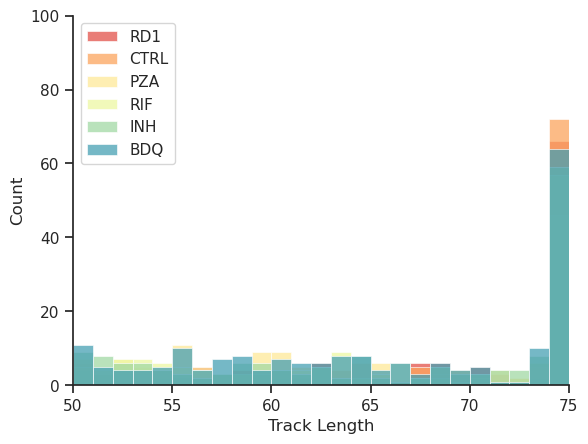

In [294]:
for n, col in enumerate(df.iteritems()):
    if '3' in col[0][1]:
        info = assay_layout.loc[eval(col[0])]
        if 'RD1' in info['Strain']:
            label = 'RD1'
        else:
            label = info['Compound']
        sns.histplot(df[col[0]], binwidth=1, alpha = 0.75, label = label, color=colours[n])#kde = True)
plt.xlabel('Track Length')
plt.xlim(50, 75)
plt.ylim(0,100)
plt.legend()
sns.despine(offset=0) 

/tmp/ipykernel_104033/2194959599.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for n, col in enumerate(df.iteritems()):


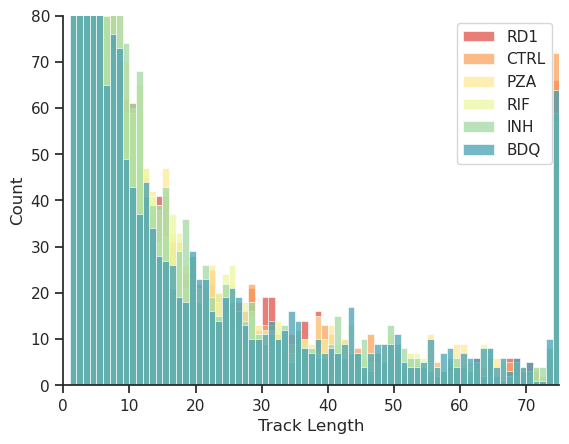

In [293]:
for n, col in enumerate(df.iteritems()):
    if '3' in col[0][1]:
        info = assay_layout.loc[eval(col[0])]
        if 'RD1' in info['Strain']:
            label = 'RD1'
        else:
            label = info['Compound']
        sns.histplot(df[col[0]], binwidth=1, alpha = 0.75, label = label, color=colours[n])#kde = True)
plt.xlabel('Track Length')
plt.xlim(0, 75)
plt.ylim(0,80)
plt.legend()
sns.despine(offset=0) 

In [83]:
row, column

(3, 9)

# Overlapping densities

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
info = assay_layout.loc[eval(col[0])]

In [338]:
for row in df3.iterrows():
    info = assay_layout.loc[eval(row[0])]
    for key in info.keys():
        df3.at[row[0], key] = info[key]

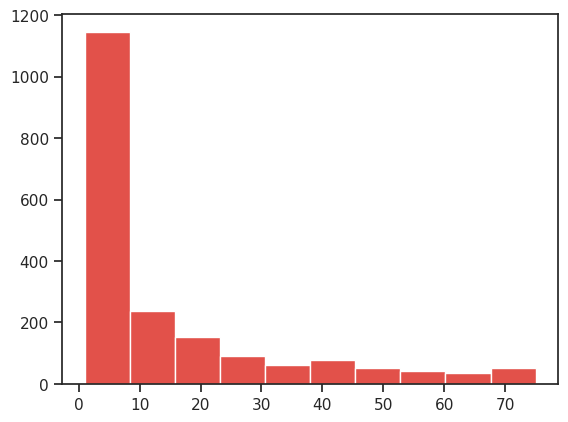

In [361]:
test = plt.hist(df[col[0]])

In [362]:
test

(array([1146.,  236.,  151.,   89.,   61.,   76.,   53.,   43.,   35.,
          51.]),
 array([ 1. ,  8.4, 15.8, 23.2, 30.6, 38. , 45.4, 52.8, 60.2, 67.6, 75. ]),
 <BarContainer object of 10 artists>)

In [365]:
df4 = pd.DataFrame(columns=['Strain', 'Compound', 'Concentration', 'Number of fully tracked cells'])

In [367]:
info = assay_layout.loc[eval(col[0])]

('(3, 4)',
 0                  18.0
 1                   1.0
 2                  28.0
 3                   4.0
 4                   1.0
                    ... 
 2798                NaN
 Strain              RD1
 Compound           CTRL
 Concentration         0
 ConcentrationEC     EC0
 Name: (3, 4), Length: 2803, dtype: object)

In [377]:
len([r for r in row[1] if r == 75])

54

In [381]:
for n, row in enumerate(df3.iterrows()):
    info = assay_layout.loc[eval(row[0])]
    df4.at[n, 'Strain'] = info['Strain']
    df4.at[n, 'Compound'] = info['Compound']
    df4.at[n, 'Concentration'] = info['Concentration']
    number = len([r for r in row[1] if r == 75])
    df4.at[n, 'Number of fully tracked cells'] = number

In [382]:

df4

Strain Compound Concentration Number of fully tracked cells
0     RD1     CTRL             0                            54
1      WT     CTRL             0                            64
2      WT      PZA            60                            38
3      WT      RIF           0.1                            46
4      WT      INH          0.04                            45
5      WT      BDQ          0.02                            54
6     RD1     CTRL             0                            49
7      WT     CTRL             0                            65
8      WT      PZA            60                            46
9      WT      RIF           0.1                            52
10     WT      INH          0.04                            49
11     WT      BDQ          0.02                            68
12    RD1     CTRL             0                            36
13     WT     CTRL             0                            46
14     WT      PZA           400                            39
15     WT      RIF             2                            35
16     WT      INH             2                            47
17     WT      BDQ           2.5                            26
18    RD1     CTRL             0                            43
19     WT     CTRL             0                            43
20     WT      PZA           400                            35
21     WT      RIF             2                            44
22     WT      INH             2                            29
23     WT      BDQ           2.5                            34

# Small multiple time series

In [392]:
tracks_df = pd.DataFrame(columns = ['Time', 'Intracellular Mtb content', 'Strain', 'Compound', 'Concentration'])

In [393]:
tracks_df

Empty DataFrame
Columns: [Time, Intracellular Mtb content, Strain, Compound, Concentration]
Index: []

In [421]:
track

OrderedDict([('ID', 343), ('t', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]), ('x', [1169.847412109375, 1172.8265380859375, 1174.5888671875, 1175.2506103515625, 1180.553955078125, 1182.6605224609375, 1182.1993408203125, 1183.4542236328125, 1182.696044921875, 1182.140869140625, 1182.6607666015625, 1183.175537109375, 1183.9273681640625, 1181.1737060546875, 1179.9722900390625, 1182.5675048828125, 1180.9970703125, 1184.2105712890625, 1176.201416015625, 1177.2314453125, 1177.5076904296875, 1173.58056640625, 1172.007568359375, 1170.9334716796875, 1170.6134033203125, 1169.008056640625, 1168.4791259765625, 1162.671142578125, 1156.9173583984375, 1160.9608154296875, 1155.3258056640625, 1147.61328125, 1147.464599609375, 1145.7923583984375, 1144.85595703125, 1143.2427978515625, 1146.328857421875, 1143.3685302734375, 1141.4693603515625, 1141.096923828125, 1143.87548828125, 1142.2440185546875, 1141.1551513671875, 1143.7059326171875, 1139.0426025390625, 1139.0738525390625, 1141.136962890625, 1139.7115478515625, 1136.5994873046875, 1137.0889892578125, 1135.1455078125, 1137.481201171875, 1137.77978515625, 1140.603515625, 1141.5006103515625, 1140.2171630859375, 1140.16552734375, 1137.4307861328125, 1138.5135498046875, 1138.242919921875, 1141.3228759765625, 1132.620849609375, 1129.785400390625, 1126.880126953125, 1136.27783203125, 1123.466552734375, 1123.466552734375, 1124.8690185546875, 1124.4195556640625, 1126.5089111328125, 1122.8775634765625, 1127.7196044921875, 1125.9307861328125, 1126.54638671875, 1125.7822265625]), ('y', [13.893421173095703, 14.674928665161133, 14.375802993774414, 12.16020679473877, 9.897769927978516, 13.432465553283691, 14.609030723571777, 14.0554838180542, 15.890345573425293, 13.777464866638184, 16.869178771972656, 19.487945556640625, 20.843780517578125, 23.63237762451172, 27.714807510375977, 25.37335777282715, 27.13897132873535, 22.792104721069336, 34.49059295654297, 29.149904251098633, 34.2733268737793, 37.11524200439453, 40.96302032470703, 38.55690002441406, 37.472389221191406, 36.869258880615234, 42.597286224365234, 53.101619720458984, 54.107269287109375, 47.837432861328125, 53.503517150878906, 58.49186706542969, 61.26840591430664, 64.55894470214844, 80.43444061279297, 73.23210144042969, 61.428958892822266, 73.25883483886719, 78.25965881347656, 68.53170776367188, 64.66354370117188, 71.34012603759766, 78.82720184326172, 74.25414276123047, 70.70987701416016, 68.67548370361328, 69.16937255859375, 70.70663452148438, 76.6936264038086, 76.61360931396484, 79.15460968017578, 72.0478515625, 74.12287139892578, 71.86528778076172, 71.28329467773438, 70.8950424194336, 72.03356170654297, 73.38528442382812, 76.65280151367188, 72.85932159423828, 79.43927001953125, 88.64515686035156, 86.92528533935547, 90.01383972167969, 93.18566131591797, 90.32048034667969, 90.32048034667969, 90.01806640625, 90.86246490478516, 89.89749145507812, 90.17449951171875, 91.52332305908203, 89.93771362304688, 91.2487564086914, 91.57733917236328]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8543770909309387, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 343), ('root', 343), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, False, False, False, False, False, False, False, False, False, False, False

In [566]:
dfs = list()
filtered_tracks = dict()
for key in tracks_dict.keys():
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) == 75]
    for track in filtered_tracks[key]:
        info = assay_layout.loc[key]
        strain = info['Strain']
        comp = info['Compound']
        conc = info['ConcentrationEC']
        d = {'Time':track['t'], 'Area':track['area'], 
     'Intracellular Mtb content':track['mean_intensity-1'],
     'Macroph. GFP expression':track['mean_intensity-0'],
     'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
     'Strain':[strain for i in range(len(track['t']))], 
     'Compound':[comp for i in range(len(track['t']))], 
     'Concentration':[conc for i in range(len(track['t']))], 
     'Cell ID':[track.ID for i in range(len(track['t']))],
     'Acquisition ID':[key for i in range(len(track['t']))]}
        dfs.append(pd.DataFrame(d))
df = pd.concat(dfs, ignore_index=True)

In [568]:
df

Time    Area  Intracellular Mtb content  Macroph. GFP expression  \
0         0   760.0                   0.005136                 0.014705   
1         1  1049.0                   0.005121                 0.013235   
2         2   934.0                   0.005116                 0.013899   
3         3   774.0                   0.005094                 0.013428   
4         4   538.0                   0.005071                 0.012774   
...     ...     ...                        ...                      ...   
81520    70  3018.0                   0.005635                 0.024949   
81521    71  2863.0                   0.005609                 0.024090   
81522    72  3047.0                   0.005600                 0.022092   
81523    73  2737.0                   0.005606                 0.021206   
81524    74  2564.0                   0.005601                 0.019352   

       Eccentricity Strain Compound Concentration  Cell ID Acquisition ID  
0          0.809516    RD1     CTRL           EC0      343         (3, 4)  
1          0.843927    RD1     CTRL           EC0      343         (3, 4)  
2          0.719524    RD1     CTRL           EC0      343         (3, 4)  
3          0.739700    RD1     CTRL           EC0      343         (3, 4)  
4          0.761300    RD1     CTRL           EC0      343         (3, 4)  
...             ...    ...      ...           ...      ...            ...  
81520      0.698306     WT      BDQ          EC99      155         (6, 9)  
81521      0.716728     WT      BDQ          EC99      155         (6, 9)  
81522      0.789115     WT      BDQ          EC99      155         (6, 9)  
81523      0.822009     WT      BDQ          EC99      155         (6, 9)  
81524      0.850803     WT      BDQ          EC99      155         (6, 9)  

[81525 rows x 10 columns]

In [465]:
sns.set_theme(style="ticks")
# palette = sns.color_palette("Spectral", n_colors=2)
sns.set_palette("rocket_r")

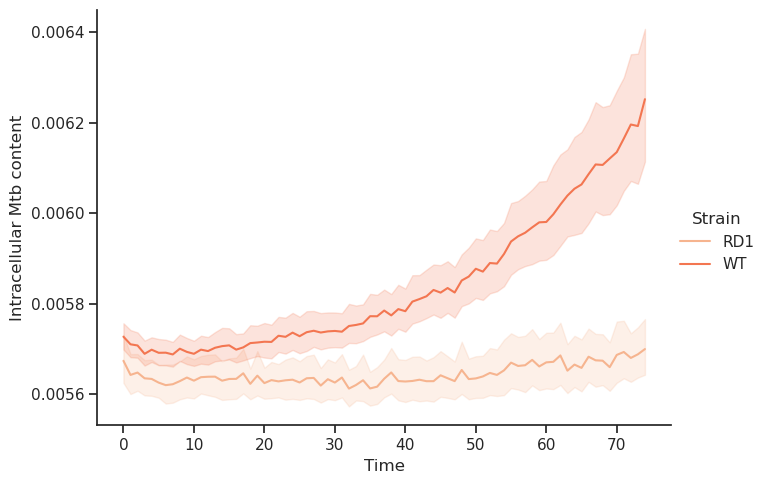

In [466]:
sns.relplot(data = df, 
            x = 'Time', 
            y = 'Intracellular Mtb content', 
            hue = 'Strain', kind = 'line', 
            aspect = 1.4,# palette = palette
           )

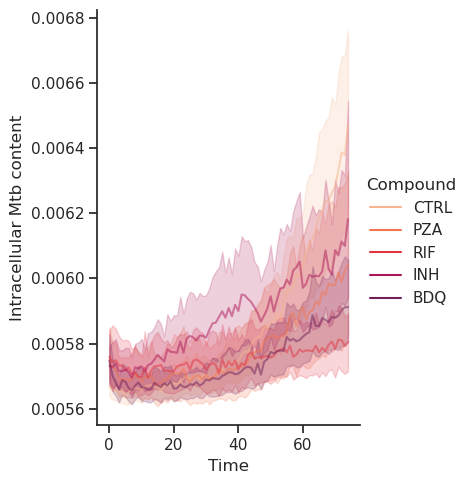

In [477]:
sns.relplot(data = df, 
            x = 'Time', 
            y = 'Intracellular Mtb content', 
            hue = 'Compound', kind = 'line', 
            aspect = 0.8, alpha = 0.5
           )

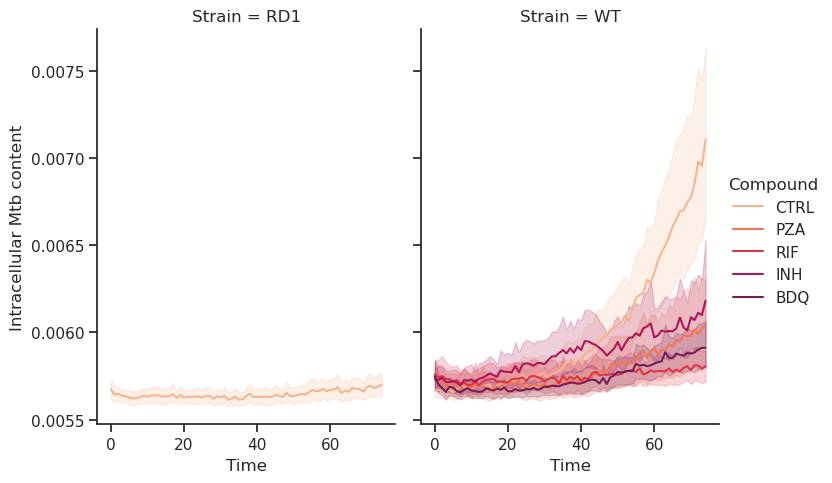

In [474]:
# Plot the lines on two facets
sns.relplot(
    data=df,
    x = 'Time', 
    y = 'Intracellular Mtb content', 
    hue="Compound",# size="Area", 
    col="Strain",
    kind="line", #size_order=["T1", "T2"], palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

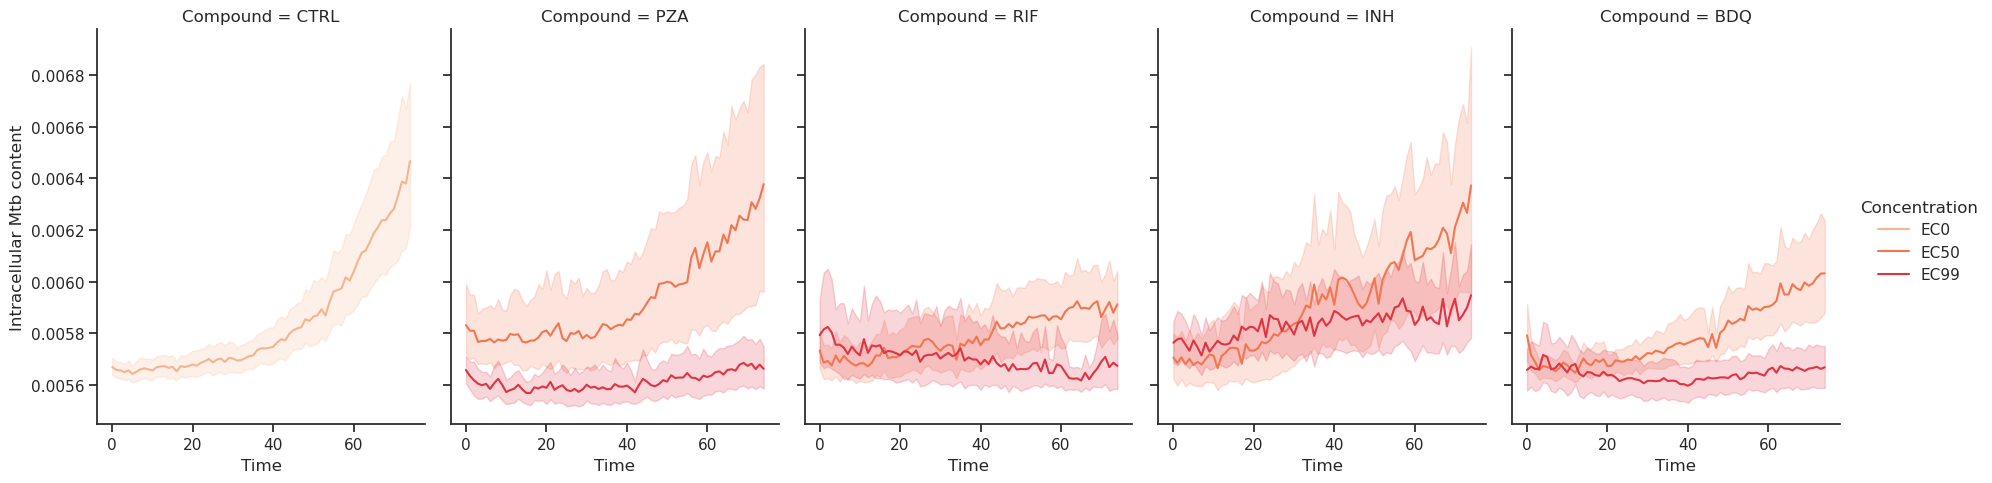

In [479]:
# Plot the lines on two facets
sns.relplot(
    data=df,
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",# size="Area", 
    col="Compound",
    hue = 'Concentration',
    kind="line", #size_order=["T1", "T2"], palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

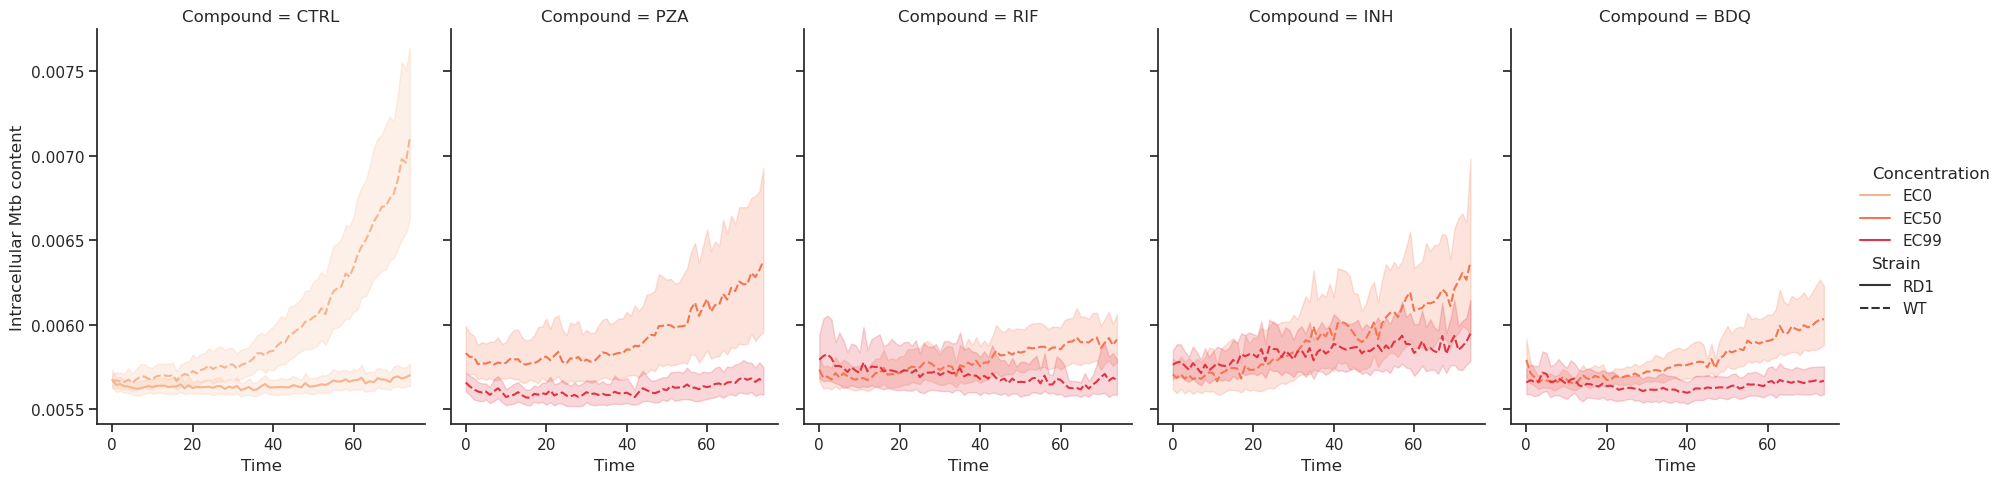

In [485]:
# Plot the lines on two facets
sns.relplot(
    data=df,
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",# size="Area", 
    col="Compound",
    hue = 'Concentration',
    kind="line", 
    style = 'Strain',#size_order=["T1", "T2"], palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)
plt.savefig('test.png', dpi = 314)

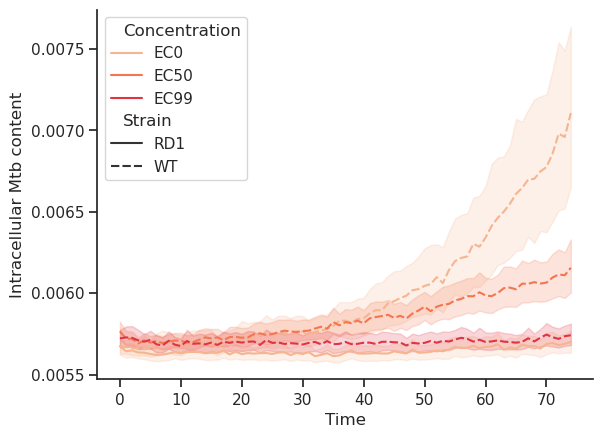

In [482]:
sns.lineplot( data=df,
                x = 'Time', 
                y = 'Intracellular Mtb content', 
                 hue = 'Concentration',
             style="Strain",)
sns.despine()

In [505]:
sns.color_palette("rocket", n_colors=5)

[(0.24525608, 0.10497384, 0.26395596),
 (0.51728314, 0.1179558, 0.35453252),
 (0.7965014, 0.10506637, 0.31063031),
 (0.94291042, 0.37549479, 0.26369821),
 (0.96443322, 0.67025402, 0.51509334)]

In [497]:
palette

[(0.94291042, 0.37549479, 0.26369821), (0.51728314, 0.1179558, 0.35453252)]

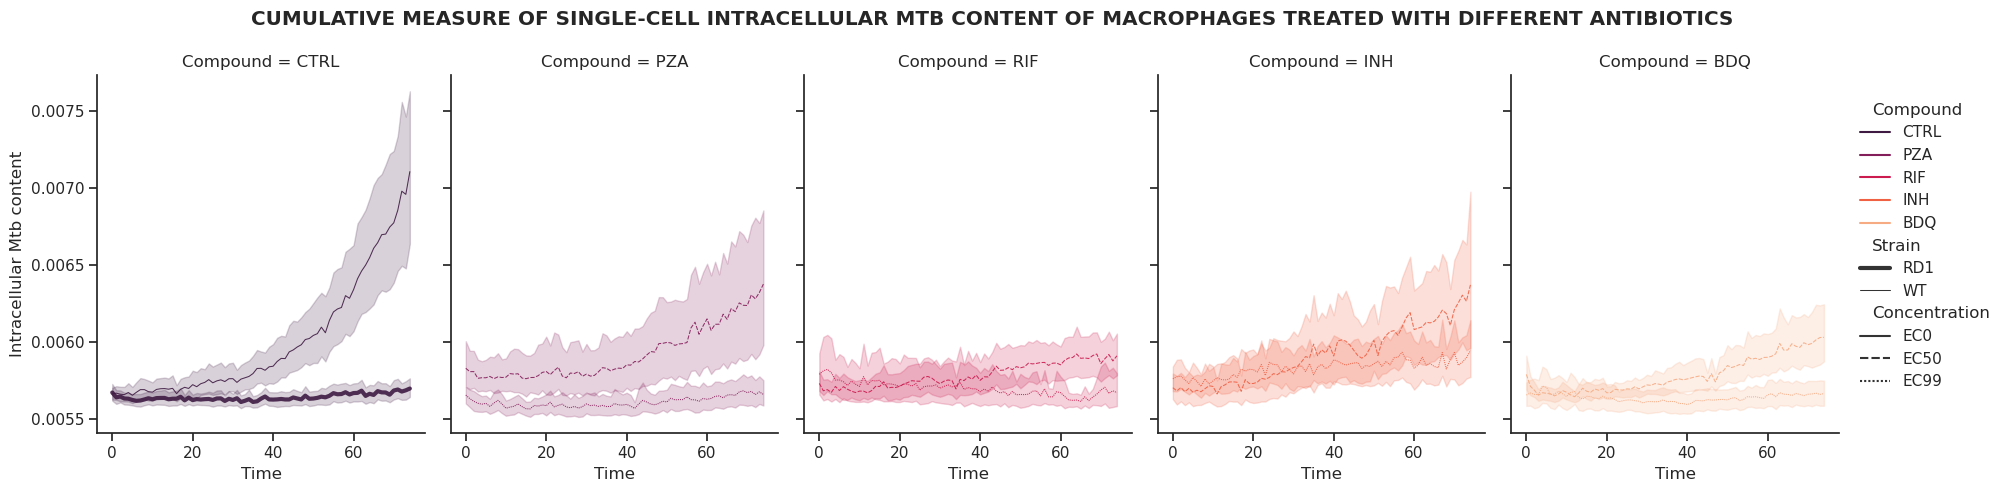

In [542]:
# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=5)

# Plot the lines on two facets
rel = sns.relplot(
    data=df,
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    size="Strain", 
    col="Compound",
    hue = 'Compound',
    kind="line", 
    style = 'Concentration',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/strain_compound_compound_concentration.png', dpi = 314)


In [486]:
df.to_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/longest_track_Mtb.pkl')  # where to save it, usually as a .pkl

#### Fitler control out

In [537]:
df.loc[df['Concentration'] != 'EC0']

Time    Area  Intracellular Mtb content Strain Compound Concentration
8850      0  1524.0                   0.005643     WT      PZA          EC50
8851      1   746.0                   0.005637     WT      PZA          EC50
8852      2   700.0                   0.005688     WT      PZA          EC50
8853      3   642.0                   0.005684     WT      PZA          EC50
8854      4   953.0                   0.005651     WT      PZA          EC50
...     ...     ...                        ...    ...      ...           ...
81520    70  3018.0                   0.005635     WT      BDQ          EC99
81521    71  2863.0                   0.005609     WT      BDQ          EC99
81522    72  3047.0                   0.005600     WT      BDQ          EC99
81523    73  2737.0                   0.005606     WT      BDQ          EC99
81524    74  2564.0                   0.005601     WT      BDQ          EC99

[51525 rows x 6 columns]

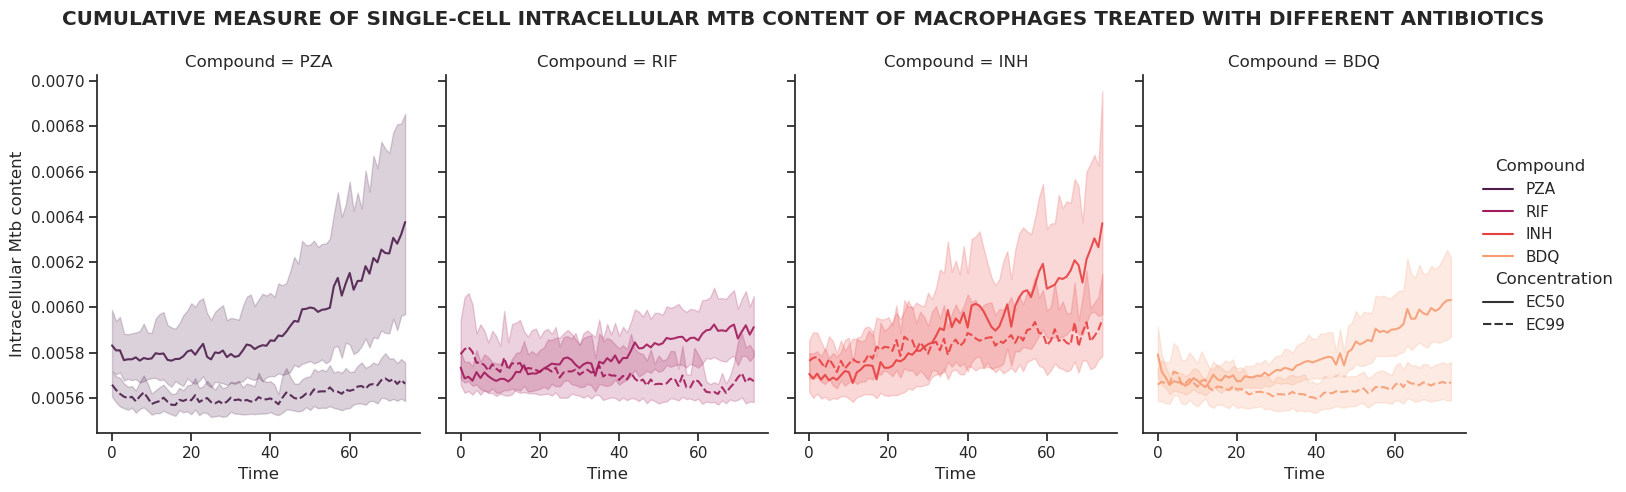

In [541]:
# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=4)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] != 'EC0'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    #size="Strain", 
    col="Compound",
    hue = 'Compound',
    kind="line", 
    style = 'Concentration',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/nocontrol_strain_compound_compound_concentration.png', dpi = 314)


# making glimpses

What do I want to show? A) tracking efficacy and B) single-cell heterogeneity

In [546]:
max(df['Area']), min(df['Area'])

(16774.0, 501.0)

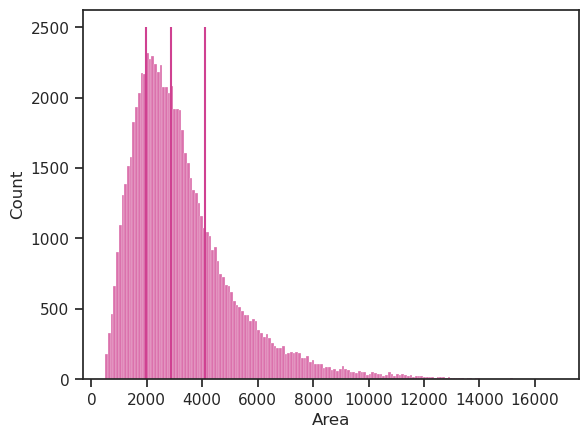

In [579]:
sns.histplot(df['Area'])
plt.vlines([df['Area'].quantile(.25), df['Area'].quantile(0.5), df['Area'].quantile(.75)], ymin = 0, ymax = 2500)

### Discretising area and eccentricity into categorical groups for plotting

In [576]:
df['Area'].quantile(.25), df['Area'].quantile(0.5), df['Area'].quantile(.75)

(1979.0, 2862.0, 4094.75)

In [582]:
df['Area'].quantile(.0)

16774.0

In [588]:
area_quartiles = pd.cut(df['Area'], bins = [df['Area'].quantile(.0), 
                                    df['Area'].quantile(.25), 
                                    df['Area'].quantile(0.5), 
                                    df['Area'].quantile(.75),
                                    df['Area'].quantile(1)], 
                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
area_quartiles

0            Lower
1            Lower
2            Lower
3            Lower
4            Lower
           ...    
81520    Upper-mid
81521    Upper-mid
81522    Upper-mid
81523    Lower-mid
81524    Lower-mid
Name: Area, Length: 81525, dtype: category
Categories (4, object): ['Lower' < 'Lower-mid' < 'Upper-mid' < 'Upper']

In [589]:
df['Area quartiles'] = area_quartiles

In [590]:
df

Time    Area  Intracellular Mtb content  Macroph. GFP expression  \
0         0   760.0                   0.005136                 0.014705   
1         1  1049.0                   0.005121                 0.013235   
2         2   934.0                   0.005116                 0.013899   
3         3   774.0                   0.005094                 0.013428   
4         4   538.0                   0.005071                 0.012774   
...     ...     ...                        ...                      ...   
81520    70  3018.0                   0.005635                 0.024949   
81521    71  2863.0                   0.005609                 0.024090   
81522    72  3047.0                   0.005600                 0.022092   
81523    73  2737.0                   0.005606                 0.021206   
81524    74  2564.0                   0.005601                 0.019352   

       Eccentricity Strain Compound Concentration  Cell ID Acquisition ID  \
0          0.809516    RD1     CTRL           EC0      343         (3, 4)   
1          0.843927    RD1     CTRL           EC0      343         (3, 4)   
2          0.719524    RD1     CTRL           EC0      343         (3, 4)   
3          0.739700    RD1     CTRL           EC0      343         (3, 4)   
4          0.761300    RD1     CTRL           EC0      343         (3, 4)   
...             ...    ...      ...           ...      ...            ...   
81520      0.698306     WT      BDQ          EC99      155         (6, 9)   
81521      0.716728     WT      BDQ          EC99      155         (6, 9)   
81522      0.789115     WT      BDQ          EC99      155         (6, 9)   
81523      0.822009     WT      BDQ          EC99      155         (6, 9)   
81524      0.850803     WT      BDQ          EC99      155         (6, 9)   

      Area quartiles  
0              Lower  
1              Lower  
2              Lower  
3              Lower  
4              Lower  
...              ...  
81520      Upper-mid  
81521      Upper-mid  
81522      Upper-mid  
81523      Lower-mid  
81524      Lower-mid  

[81525 rows x 11 columns]

In [591]:
eccentricity_quartiles = pd.cut(df['Eccentricity'], bins = [df['Eccentricity'].quantile(.0), 
                                    df['Eccentricity'].quantile(.25), 
                                    df['Eccentricity'].quantile(0.5), 
                                    df['Eccentricity'].quantile(.75),
                                    df['Eccentricity'].quantile(1)], 
                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
eccentricity_quartiles

0        Lower-mid
1        Upper-mid
2        Lower-mid
3        Lower-mid
4        Lower-mid
           ...    
81520    Lower-mid
81521    Lower-mid
81522    Lower-mid
81523    Upper-mid
81524    Upper-mid
Name: Eccentricity, Length: 81525, dtype: category
Categories (4, object): ['Lower' < 'Lower-mid' < 'Upper-mid' < 'Upper']

In [592]:
df['Eccentricity quartiles'] = eccentricity_quartiles

In [616]:
df['Total Mtb content'] = df['Intracellular Mtb content']*df['Area']

# Plotting quartile morphology groupings

Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

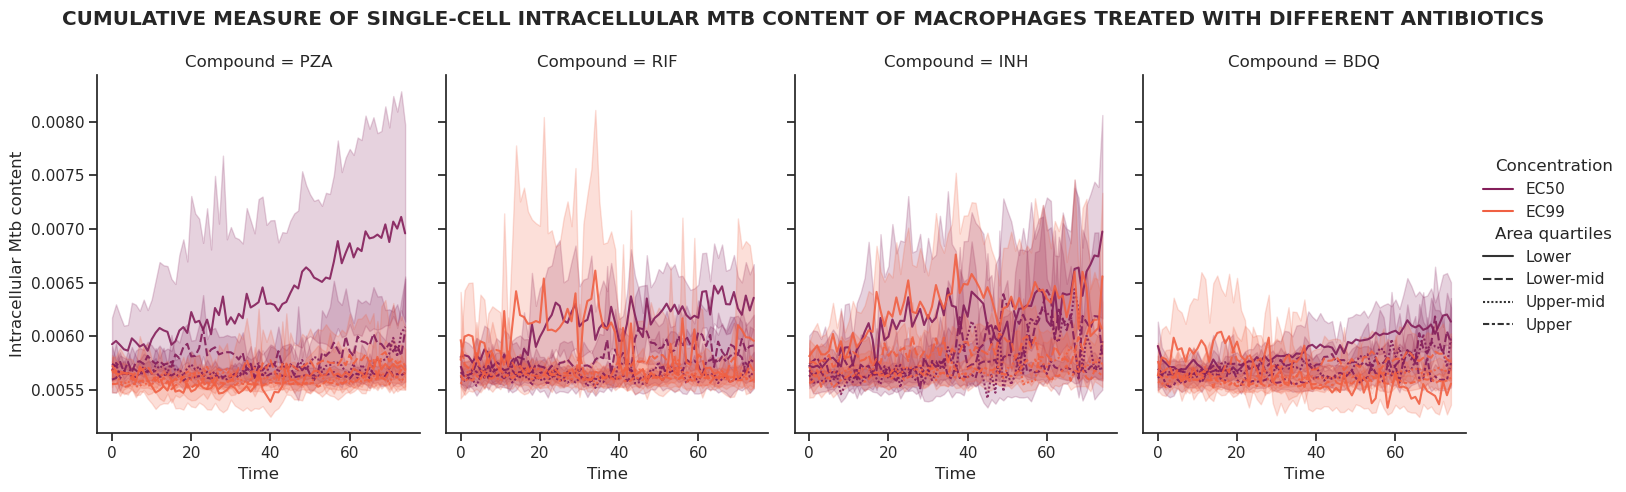

In [621]:
# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=2)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] != 'EC0'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    #size="Strain", 
    col="Compound",
    hue = 'Concentration',
    kind="line", 
    style = 'Area quartiles',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/nocontrol_strain_compound_compound_concentration.png', dpi = 314)


Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

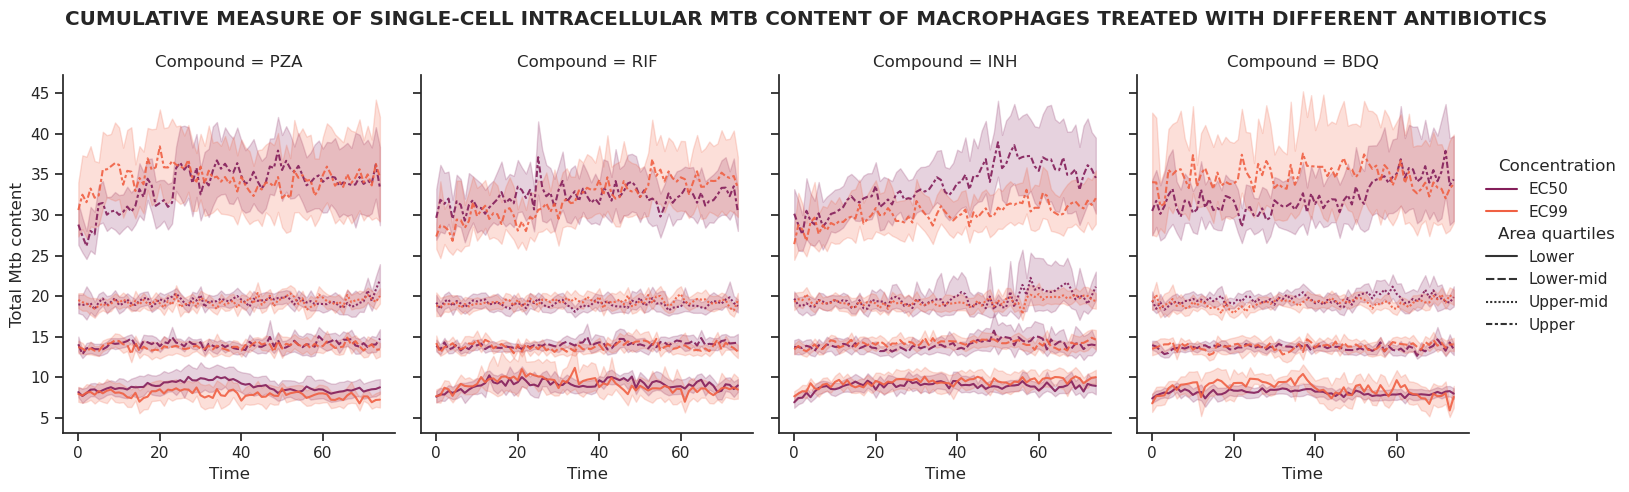

In [620]:
# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=2)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] != 'EC0'],
    x = 'Time', 
    y = 'Total Mtb content', 
#     hue="",
    #size="Strain", 
    col="Compound",
    hue = 'Concentration',
    kind="line", 
    style = 'Area quartiles',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/nocontrol_strain_compound_compound_concentration.png', dpi = 314)


Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

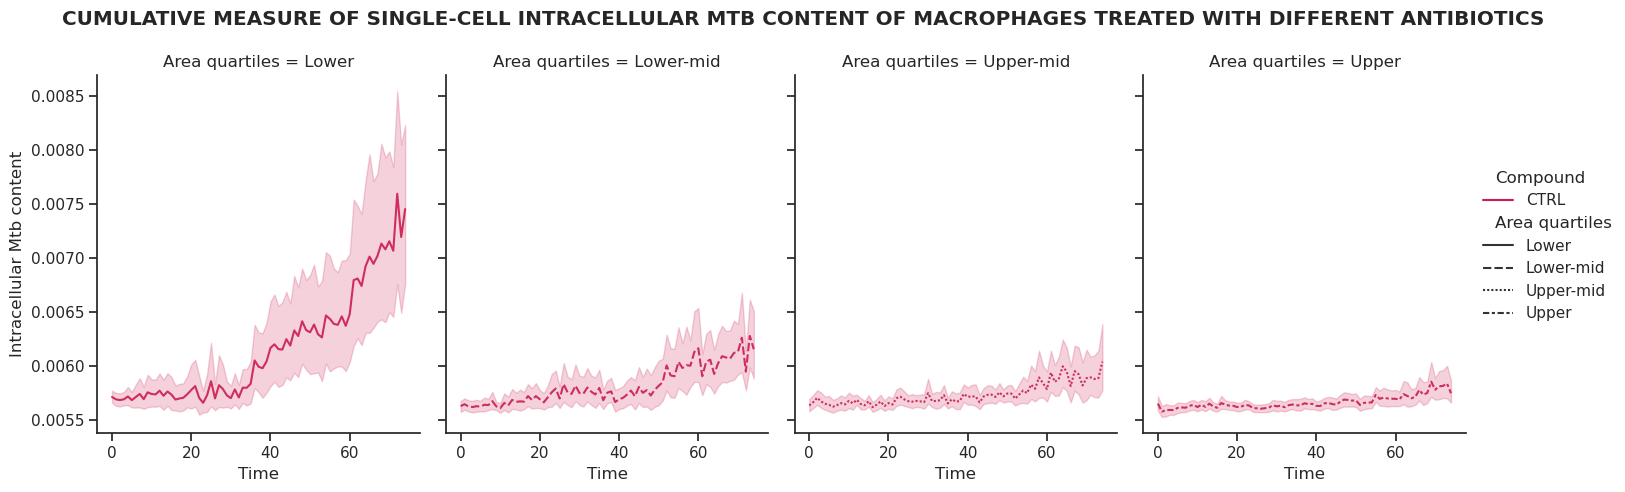

In [619]:

# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=1)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] == 'EC0'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    #size="Strain", 
    col="Area quartiles",
    hue = 'Compound',
    kind="line", 
    style = 'Area quartiles',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/nocontrol_strain_compound_compound_concentration.png', dpi = 314)


Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

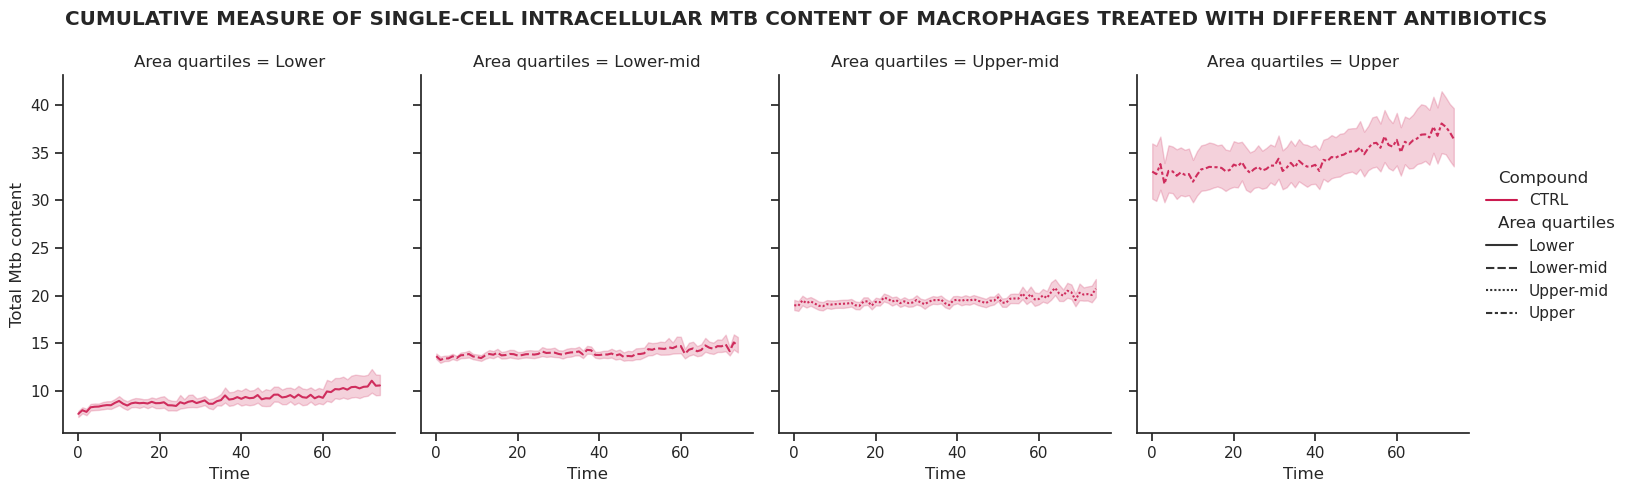

In [618]:

# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=1)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] == 'EC0'],
    x = 'Time', 
    y = 'Total Mtb content', 
#     hue="",
    #size="Strain", 
    col="Area quartiles",
    hue = 'Compound',
    kind="line", 
    style = 'Area quartiles',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/nocontrol_strain_compound_compound_concentration.png', dpi = 314)


Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

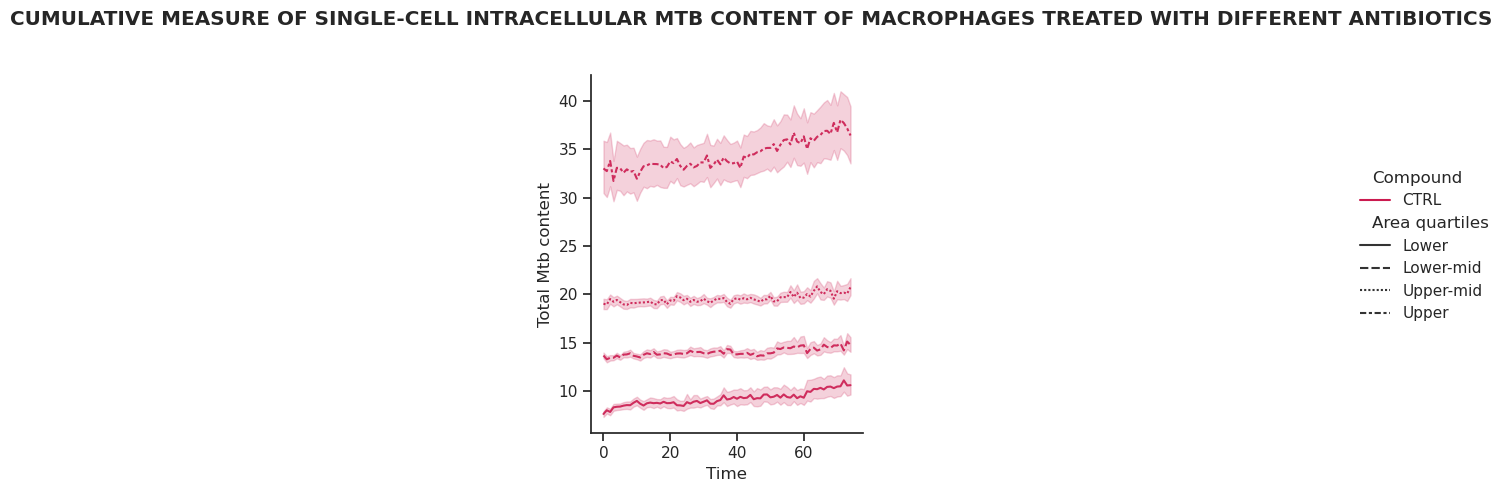

In [622]:

# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=1)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] == 'EC0'],
    x = 'Time', 
    y = 'Total Mtb content', 
#     hue="",
    #size="Strain", 
    #col="Area quartiles",
    hue = 'Compound',
    kind="line", 
    style = 'Area quartiles',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/nocontrol_strain_compound_compound_concentration.png', dpi = 314)


Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

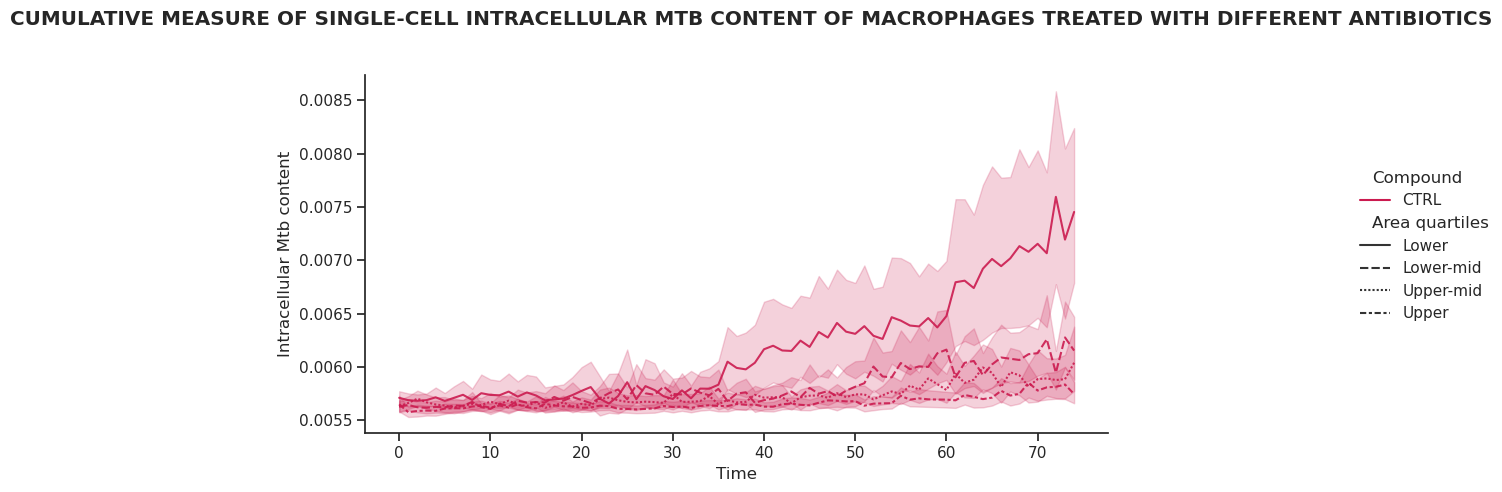

In [624]:

# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=1)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] == 'EC0'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    #size="Strain", 
    #col="Area quartiles",
    hue = 'Compound',
    kind="line", 
    style = 'Area quartiles',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=1.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/nocontrol_strain_compound_compound_concentration.png', dpi = 314)


Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

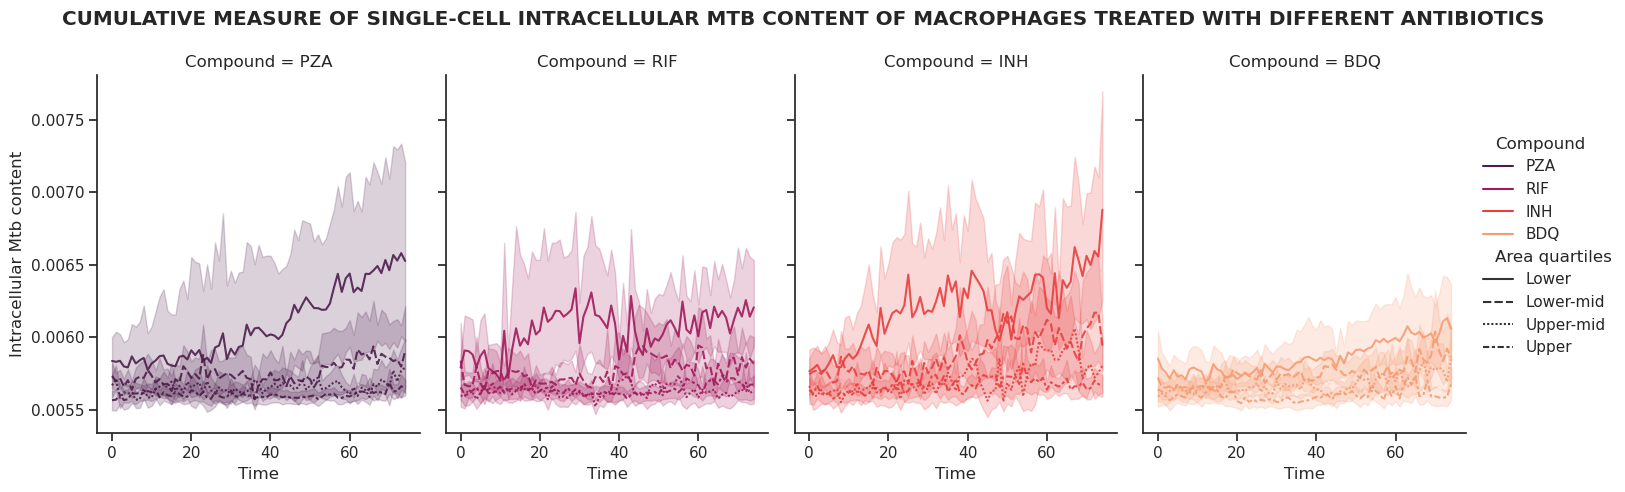

In [629]:

# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=4)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] != 'EC0'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    #size="Strain", 
    col="Compound",
    hue = 'Compound',
    kind="line", 
    style = 'Area quartiles',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=0.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/nocontrol_strain_compound_compound_concentration.png', dpi = 314)


Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

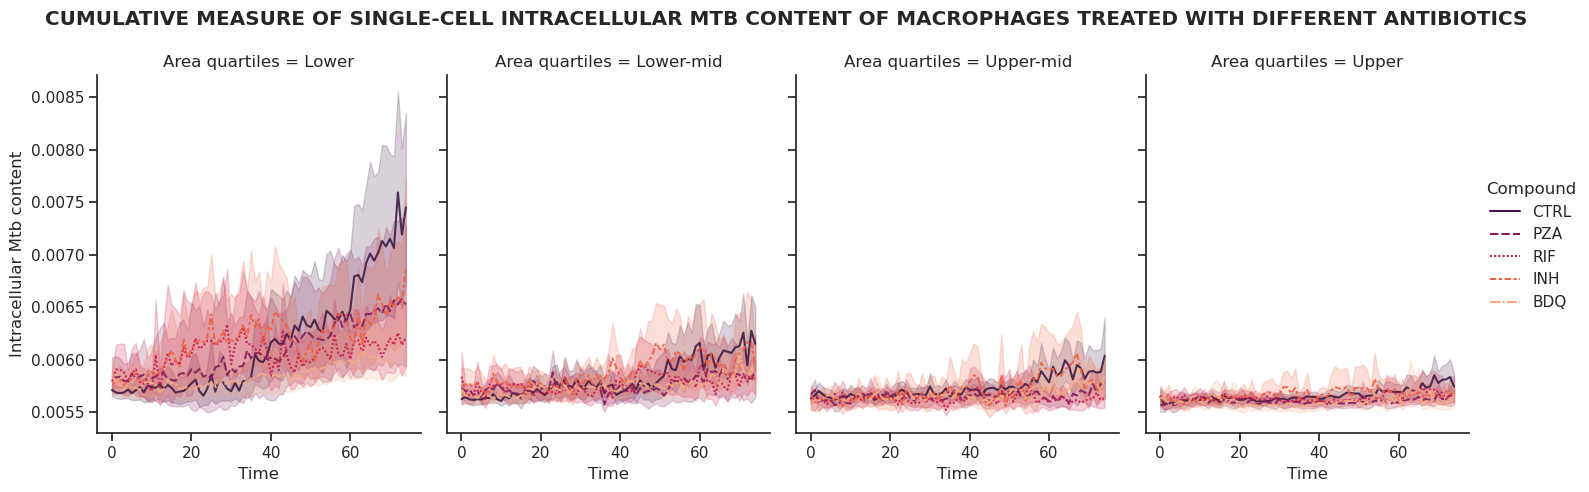

In [614]:

# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=5)

# Plot the lines on two facets
rel = sns.relplot(
    data=df,#.loc[df['Concentration'] == 'EC0'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    #size="Strain", 
    col="Area quartiles",
    hue = 'Compound',
    kind="line", 
    style = 'Compound',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/nocontrol_strain_compound_compound_concentration.png', dpi = 314)


Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

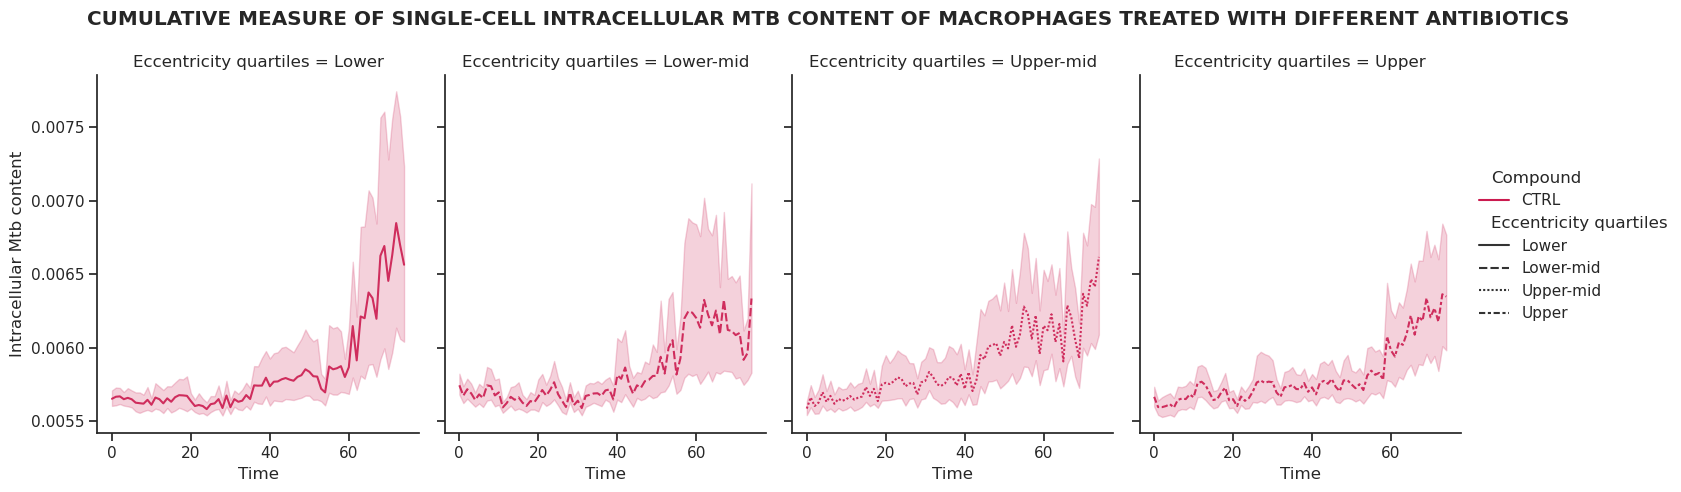

In [611]:

# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=1)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] == 'EC0'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    #size="Strain", 
    col="Eccentricity quartiles",
    hue = 'Compound',
    kind="line", 
    style = 'Eccentricity quartiles',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefig('/mnt/DATA/macrohet/results/preliminary_sc_measures/nocontrol_strain_compound_compound_concentration.png', dpi = 314)


Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

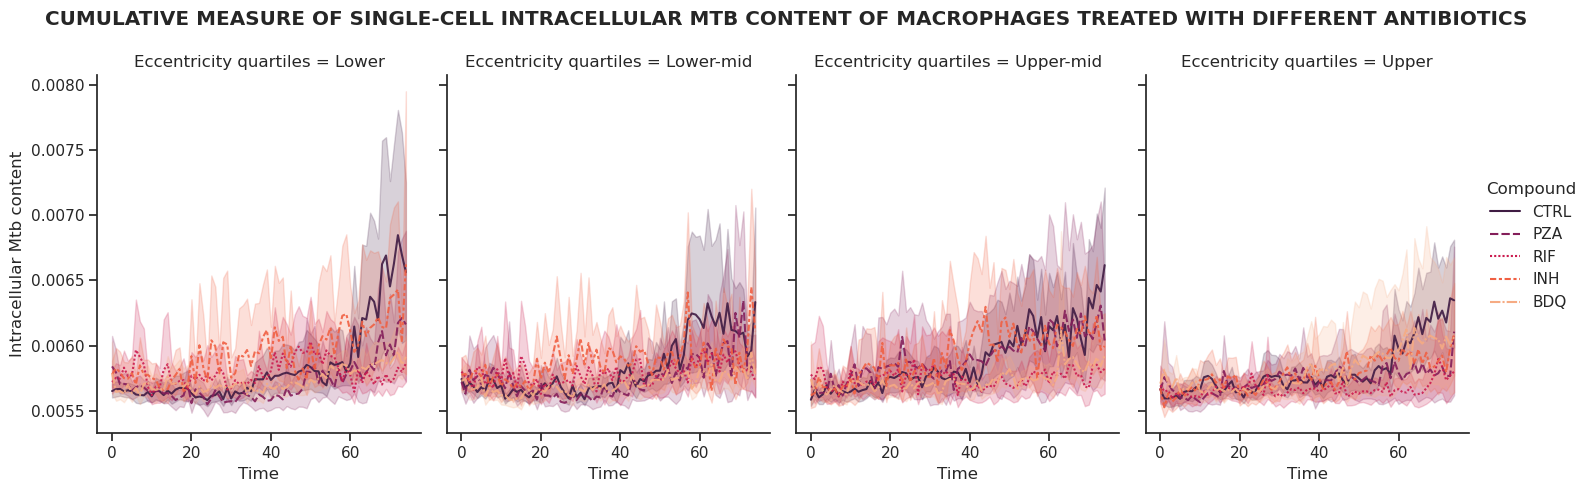

In [615]:

# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=5)

# Plot the lines on two facets
rel = sns.relplot(
    data=df,#.loc[df['Concentration'] == 'EC0'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    #size="Strain", 
    col="Eccentricity quartiles",
    hue = 'Compound',
    kind="line", 
    style = 'Compound',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefi

# Extracting other params

In [630]:
track

OrderedDict([('ID', 155), ('t', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]), ('x', [555.6489868164062, 555.6489868164062, 554.15625, 550.792236328125, 548.7384033203125, 548.7949829101562, 551.285888671875, 551.1671142578125, 557.8827514648438, 566.8692016601562, 569.989990234375, 577.5692138671875, 581.3795776367188, 595.4539794921875, 581.2628173828125, 575.5599975585938, 589.4116821289062, 590.4449462890625, 582.4705200195312, 583.2623291015625, 585.3935546875, 579.4888916015625, 583.693115234375, 587.2254028320312, 582.9640502929688, 575.3014526367188, 587.5607299804688, 583.5360107421875, 582.0842895507812, 580.2901000976562, 580.5438232421875, 580.2474975585938, 576.3912353515625, 577.4430541992188, 575.4462890625, 574.3222045898438, 569.987060546875, 573.613525390625, 569.923828125, 572.4583129882812, 572.1759643554688, 572.1536254882812, 570.9841918945312, 573.595947265625, 572.2936401367188, 572.4227905273438, 567.7813110351562, 567.6566162109375, 568.566162109375, 568.9751586914062, 570.5742797851562, 569.8197631835938, 567.7682495117188, 571.4170532226562, 573.3637084960938, 570.4962768554688, 568.7824096679688, 568.0635986328125, 564.9378662109375, 565.3991088867188, 564.0131225585938, 564.7672729492188, 566.0281372070312, 565.7327270507812, 565.4685668945312, 567.3826293945312, 567.4772338867188, 566.4212036132812, 566.0785522460938, 561.9896240234375, 559.6630249023438, 556.4575805664062, 559.9058227539062, 565.0142211914062, 564.9703369140625]), ('y', [1179.639892578125, 1179.639892578125, 1165.4315185546875, 1156.6915283203125, 1153.1190185546875, 1148.5025634765625, 1146.91845703125, 1154.8857421875, 1142.20068359375, 1143.6700439453125, 1136.7921142578125, 1131.4114990234375, 1128.8916015625, 1129.5460205078125, 1141.032958984375, 1142.59912109375, 1140.54931640625, 1149.77685546875, 1155.2216796875, 1156.9462890625, 1158.693603515625, 1161.2110595703125, 1157.1978759765625, 1154.794189453125, 1153.989990234375, 1160.920654296875, 1163.98046875, 1156.7918701171875, 1161.5574951171875, 1161.3612060546875, 1159.80712890625, 1162.232177734375, 1165.9130859375, 1162.2425537109375, 1164.1739501953125, 1168.171875, 1170.8504638671875, 1167.345703125, 1169.4783935546875, 1168.2698974609375, 1173.130859375, 1173.0162353515625, 1174.135986328125, 1172.203857421875, 1174.304443359375, 1174.754150390625, 1176.766357421875, 1176.318359375, 1174.4981689453125, 1176.944580078125, 1179.511474609375, 1175.01318359375, 1177.210205078125, 1174.3978271484375, 1175.0758056640625, 1175.3173828125, 1175.1661376953125, 1174.740234375, 1175.06982421875, 1176.091064453125, 1173.7490234375, 1172.088623046875, 1175.281982421875, 1175.75830078125, 1175.7769775390625, 1176.94189453125, 1178.3955078125, 1177.797119140625, 1178.4970703125, 1179.50244140625, 1177.240234375, 1178.1156005859375, 1178.5146484375, 1180.512939453125, 1181.5452880859375]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 155), ('root', 155), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [631]:
def msd_calc(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

In [654]:
for i in range(1, len(track)):
    x1, y1 = track['x'][i-1], track['y'][i-1]
    x2, y2 = track['x'][i], track['y'][i]
    df.at[i, 'MSD'] = msd_calc(x1,y1,x2,y2)
    print(msd_calc(x1, y1, x2, y2))
    break

0.0


[0,
 3.07992622385405,
 1.7875346233001037,
 2.312308485553916,
 5.76576845397335,
 4.114814613306541,
 1.2637223213920847,
 1.3715484131870799,
 1.9853343846924982,
 2.184601801061178,
 3.135121726875656,
 2.668881441389585,
 1.5503349238448159,
 3.9190469297274286,
 4.255541588986989,
 3.495357915677279,
 2.3629760829173487,
 5.405722692777534,
 14.17748902978051,
 5.439109872109729,
 5.130864521244539,
 4.84755450769558,
 4.156888362434027,
 2.6349760106683395,
 1.1307552506973626,
 1.7149064609205977,
 5.75239644827556,
 12.003070163657412,
 5.841007056777648,
 7.460589358061363,
 7.9911104506810124,
 9.185132971683583,
 2.7805168961151625,
 3.6910752067451944,
 15.903088314203687,
 7.380783975484491,
 12.19991547801287,
 12.1946505372064,
 5.349307134310256,
 9.735077842081507,
 4.762679249601671,
 6.87302300038074,
 7.565840063851094,
 5.236349334517328,
 5.857343007149334,
 2.0346333095911593,
 2.121402961202388,
 2.096421326006747,
 6.747517517311979,
 0.49599888788207225,
 3.1

# Adding more info to tracks

In [705]:
dfs = list()
filtered_tracks = dict()
for key in tracks_dict.keys():
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) == 75]
    for track in filtered_tracks[key]:
        info = assay_layout.loc[key]
        strain = info['Strain']
        comp = info['Compound']
        conc = info['ConcentrationEC']
        d = {'Time':track['t'], 'Area':track['area'], 
     'Intracellular Mtb content':track['mean_intensity-1'],
     'Macroph. GFP expression':track['mean_intensity-0'],
     'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
     'MSD': [msd_calc(track['x'][i-1], track['y'][i-1], 
                      track['x'][i], track['y'][i]) 
               if i != 0 else 0
             for i in range(0, len(track))],
     'Strain':[strain for i in range(len(track['t']))], 
     'Compound':[comp for i in range(len(track['t']))], 
     'Concentration':[conc for i in range(len(track['t']))], 
     'Cell ID':[track.ID for i in range(len(track['t']))],
     'Acquisition ID':[key for i in range(len(track['t']))]}
        dfs.append(pd.DataFrame(d))

Time    Area  Intracellular Mtb content  Macroph. GFP expression  \
0         0   760.0                   0.005136                 0.014705   
1         1  1049.0                   0.005121                 0.013235   
2         2   934.0                   0.005116                 0.013899   
3         3   774.0                   0.005094                 0.013428   
4         4   538.0                   0.005071                 0.012774   
...     ...     ...                        ...                      ...   
81520    70  3018.0                   0.005635                 0.024949   
81521    71  2863.0                   0.005609                 0.024090   
81522    72  3047.0                   0.005600                 0.022092   
81523    73  2737.0                   0.005606                 0.021206   
81524    74  2564.0                   0.005601                 0.019352   

       Eccentricity       MSD Strain Compound Concentration  Cell ID  \
0          0.809516  0.000000    RD1     CTRL           EC0      343   
1          0.843927  3.079926    RD1     CTRL           EC0      343   
2          0.719524  1.787535    RD1     CTRL           EC0      343   
3          0.739700  2.312308    RD1     CTRL           EC0      343   
4          0.761300  5.765768    RD1     CTRL           EC0      343   
...             ...       ...    ...      ...           ...      ...   
81520      0.698306  3.245095     WT      BDQ          EC99      155   
81521      0.716728  3.322821     WT      BDQ          EC99      155   
81522      0.789115  3.471255     WT      BDQ          EC99      155   
81523      0.822009  5.485335     WT      BDQ          EC99      155   
81524      0.850803  1.033281     WT      BDQ          EC99      155   

      Acquisition ID  
0             (3, 4)  
1             (3, 4)  
2             (3, 4)  
3             (3, 4)  
4             (3, 4)  
...              ...  
81520         (6, 9)  
81521         (6, 9)  
81522         (6, 9)  
81523         (6, 9)  
81524         (6, 9)  

[81525 rows x 11 columns]

<AxesSubplot:xlabel='MSD', ylabel='Count'>

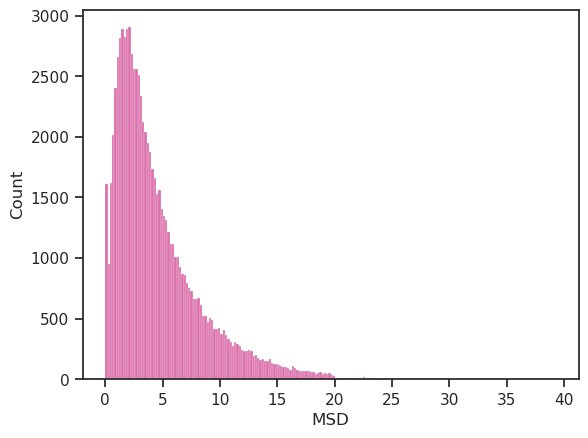

In [673]:
sns.histplot(df['MSD'])

In [674]:
msd_quartiles = pd.cut(df['MSD'], bins = [df['MSD'].quantile(.0), 
                                    df['MSD'].quantile(.25), 
                                    df['MSD'].quantile(0.5), 
                                    df['MSD'].quantile(.75),
                                    df['MSD'].quantile(1)], 
                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
msd_quartiles

0              NaN
1        Lower-mid
2            Lower
3        Lower-mid
4        Upper-mid
           ...    
81520    Lower-mid
81521    Lower-mid
81522    Upper-mid
81523    Upper-mid
81524        Lower
Name: MSD, Length: 81525, dtype: category
Categories (4, object): ['Lower' < 'Lower-mid' < 'Upper-mid' < 'Upper']

In [675]:
df['MSD quartiles'] = msd_quartiles

Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

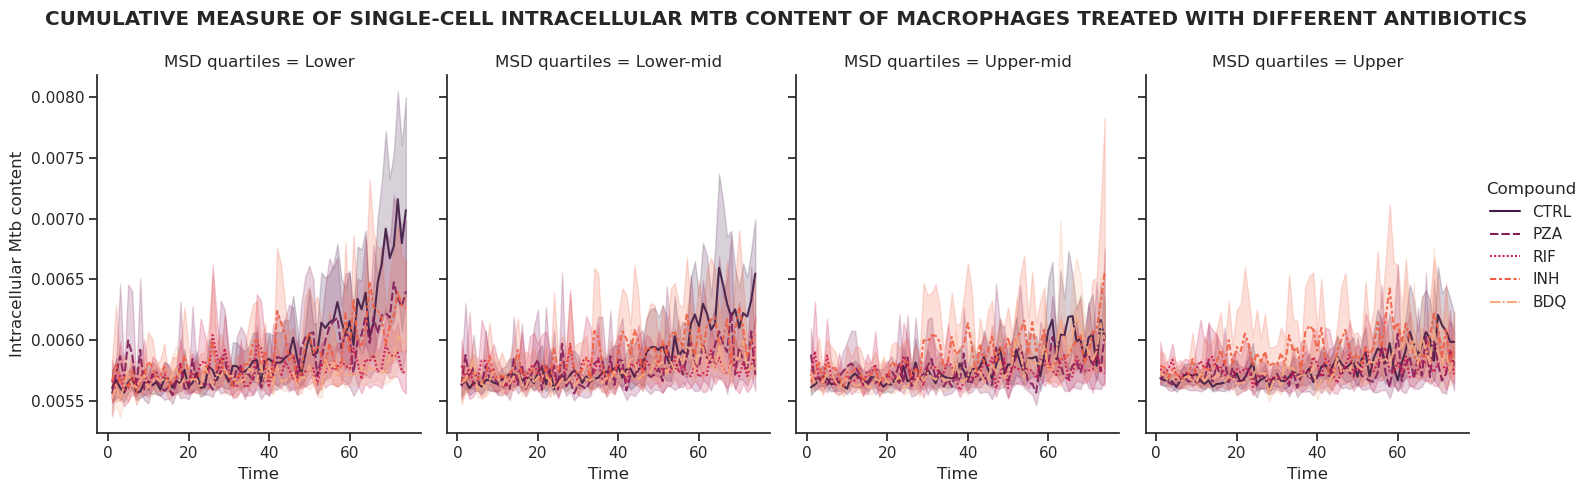

In [676]:
# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=5)

# Plot the lines on two facets
rel = sns.relplot(
    data=df,#.loc[df['Concentration'] == 'EC0'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    #size="Strain", 
    col="MSD quartiles",
    hue = 'Compound',
    kind="line", 
    style = 'Compound',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefi

Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF INFECTED MACROPHAGES')

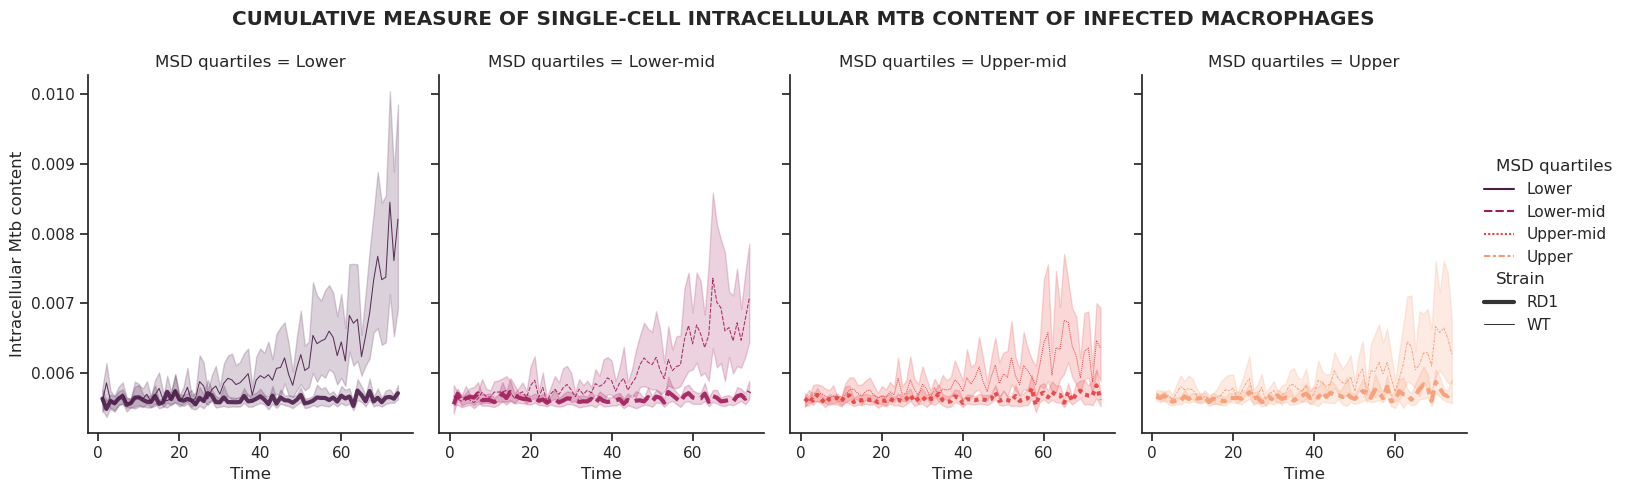

In [682]:
# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=4)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] == 'EC0'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    size="Strain", 
    col="MSD quartiles",
    hue = 'MSD quartiles',
    kind="line", 
    style = 'MSD quartiles',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF INFECTED MACROPHAGES',weight='bold')
# plt.savefi

Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS')

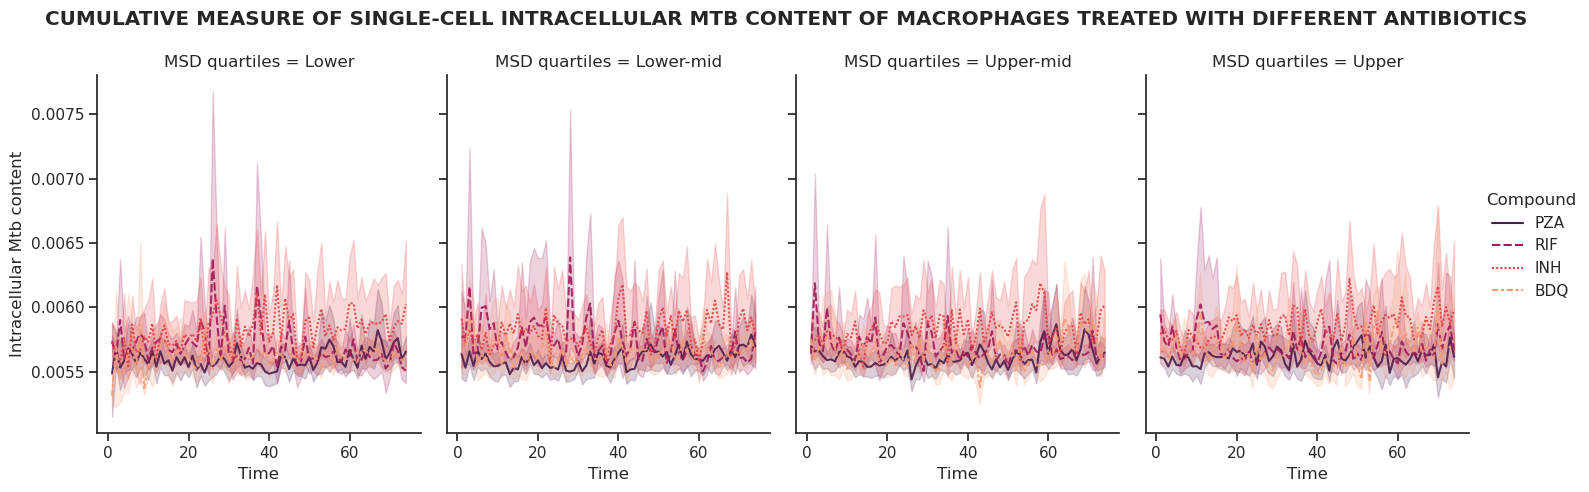

In [680]:
# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=4)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Concentration'] == 'EC99'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
#     hue="",
    #size="Strain", 
    col="MSD quartiles",
    hue = 'Compound',
    kind="line", 
    style = 'Compound',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF MACROPHAGES TREATED WITH DIFFERENT ANTIBIOTICS',weight='bold')
# plt.savefi

In [954]:
palette[1]

(0.63139686, 0.10067417, 0.35664819)

Text(0.5, 0.98, 'CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF INFECTED MACROPHAGES')

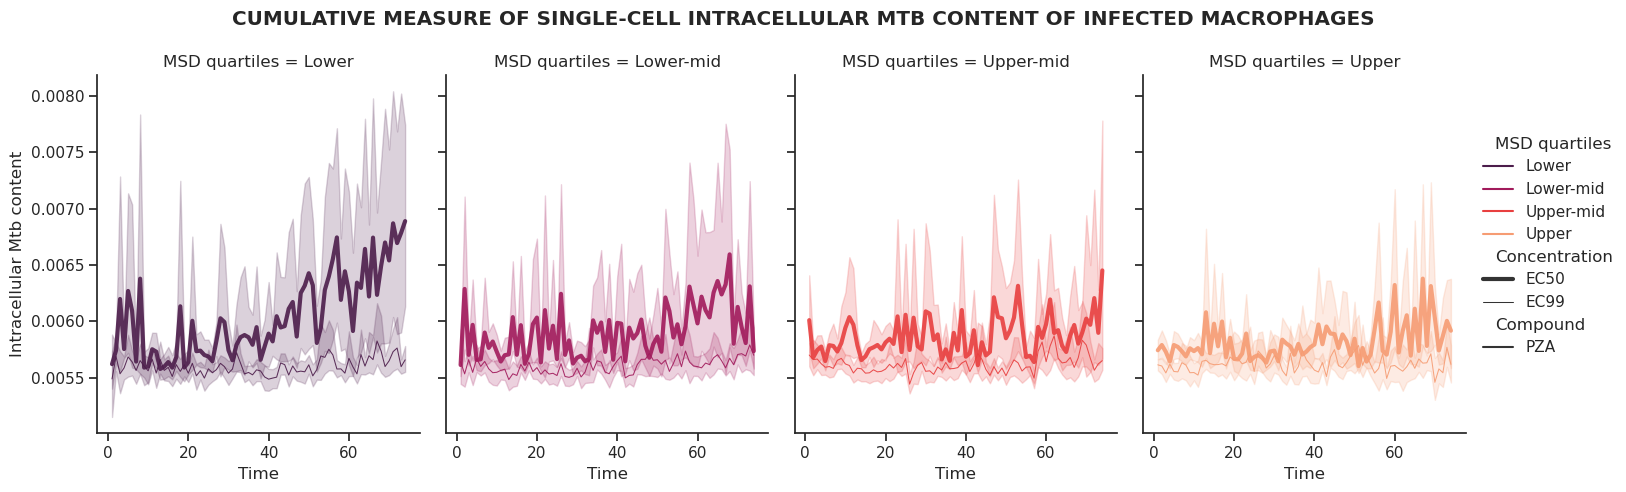

In [684]:
# sns.set_palette("PiYG")
palette = sns.color_palette("rocket", n_colors=4)

# Plot the lines on two facets
rel = sns.relplot(
    data=df.loc[df['Compound'] == 'PZA'],
    x = 'Time', 
    y = 'Intracellular Mtb content', 
    size="Concentration", 
    col="MSD quartiles",
    hue = 'MSD quartiles',
    kind="line", 
    style = 'Compound',#size_order=["T1", "T2"], 
    palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
    alpha = 0.9
)
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('CUMULATIVE MEASURE OF SINGLE-CELL INTRACELLULAR MTB CONTENT OF INFECTED MACROPHAGES',weight='bold')


# Creating glimpses

In [706]:
dfs = list()
filtered_tracks = dict()
for key in tracks_dict.keys():
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) == 75]
    for track in filtered_tracks[key]:
        info = assay_layout.loc[key]
        strain = info['Strain']
        comp = info['Compound']
        conc = info['ConcentrationEC']
        d = {'Time':track['t'], 'x':track['x'],
             'y':track['y'],'Area':track['area'], 
     'Intracellular Mtb content':track['mean_intensity-1'],
     'Macroph. GFP expression':track['mean_intensity-0'],
     'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
     'MSD': [msd_calc(track['x'][i-1], track['y'][i-1], 
                      track['x'][i], track['y'][i]) 
               if i != 0 else 0
             for i in range(0, len(track))],
     'Strain':[strain for i in range(len(track['t']))], 
     'Compound':[comp for i in range(len(track['t']))], 
     'Concentration':[conc for i in range(len(track['t']))], 
     'Cell ID':[track.ID for i in range(len(track['t']))],
     'Acquisition ID':[key for i in range(len(track['t']))]}
        dfs.append(pd.DataFrame(d))
df = pd.concat(dfs, ignore_index=True)

In [968]:
df.to_pickle('added_info_tracks.pkl')

In [688]:
assay_layout

Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

In [709]:
## picking EC99 PZA as example 
tracks_df = df[df['Acquisition ID']==(5,6)]

In [969]:
tracks_df.to_pickle('5,6_track_df.pkl')

In [710]:
tracks_df

Time           x            y    Area  Intracellular Mtb content  \
53400     0  843.888977     9.895291  1423.0                   0.005217   
53401     1  842.016602     8.402156  1206.0                   0.005233   
53402     2  854.697998    12.947233  2331.0                   0.005259   
53403     3  853.580505    11.769628  1745.0                   0.005243   
53404     4  853.345703    12.378826  1993.0                   0.005525   
...     ...         ...          ...     ...                        ...   
56320    70  178.384598  1155.093018  4675.0                   0.005638   
56321    71  200.807510  1140.815552  3834.0                   0.005791   
56322    72  198.752075  1142.213135  3965.0                   0.005737   
56323    73  199.767929  1142.548218  3792.0                   0.005731   
56324    74  191.897751  1145.447876  3961.0                   0.005699   

       Macroph. GFP expression  Eccentricity        MSD Strain Compound  \
53400                 0.015092      0.958017   0.000000     WT      PZA   
53401                 0.017785      0.959472   2.394837     WT      PZA   
53402                 0.015358      0.938589  13.471286     WT      PZA   
53403                 0.015071      0.931874   1.623436     WT      PZA   
53404                 0.016826      0.929846   0.652882     WT      PZA   
...                        ...           ...        ...    ...      ...   
56320                 0.035036      0.976493   5.144382     WT      PZA   
56321                 0.046956      0.932750  26.582570     WT      PZA   
56322                 0.040138      0.944715   2.485569     WT      PZA   
56323                 0.039431      0.950185   1.069691     WT      PZA   
56324                 0.037088      0.945567   8.387355     WT      PZA   

      Concentration  Cell ID Acquisition ID  
53400          EC99      307         (5, 6)  
53401          EC99      307         (5, 6)  
53402          EC99      307         (5, 6)  
53403          EC99      307         (5, 6)  
53404          EC99      307         (5, 6)  
...             ...      ...            ...  
56320          EC99      158         (5, 6)  
56321          EC99      158         (5, 6)  
56322          EC99      158         (5, 6)  
56323          EC99      158         (5, 6)  
56324          EC99      158         (5, 6)  

[2925 rows x 13 columns]

In [712]:
tracks_df.loc[tracks_df['Intracellular Mtb content'].idxmax()]

Time                                 44
x                            922.763916
y                            375.779785
Area                             1703.0
Intracellular Mtb content        0.0087
Macroph. GFP expression        0.072102
Eccentricity                   0.796489
MSD                            4.293594
Strain                               WT
Compound                            PZA
Concentration                      EC99
Cell ID                             431
Acquisition ID                   (5, 6)
Name: 54569, dtype: object

In [713]:
tracks_df.loc[tracks_df['Intracellular Mtb content'].idxmin()]

Time                                 73
x                              9.147012
y                            980.150269
Area                              619.0
Intracellular Mtb content      0.005074
Macroph. GFP expression        0.021289
Eccentricity                   0.787484
MSD                            3.421689
Strain                               WT
Compound                            PZA
Concentration                      EC99
Cell ID                             193
Acquisition ID                   (5, 6)
Name: 55498, dtype: object

In [714]:
cell_ID_193 = tracks_df[tracks_df['Cell ID']==193]
cell_ID_431 = tracks_df[tracks_df['Cell ID']==431]

In [715]:
cell_ID_431

Time           x           y    Area  Intracellular Mtb content  \
54525     0  927.022827  392.380096  2544.0                   0.005816   
54526     1  929.788879  390.037354  2705.0                   0.005753   
54527     2  933.411438  386.697540  2202.0                   0.005769   
54528     3  936.937927  392.752991  1498.0                   0.005817   
54529     4  939.611145  384.385254  1952.0                   0.005800   
...     ...         ...         ...     ...                        ...   
54595    70  894.532715  346.507751  2001.0                   0.007900   
54596    71  896.276428  348.002594  2308.0                   0.007694   
54597    72  895.013977  346.771790  2147.0                   0.007720   
54598    73  895.066040  349.307098  2286.0                   0.007723   
54599    74  892.424866  351.003967  2010.0                   0.007881   

       Macroph. GFP expression  Eccentricity       MSD Strain Compound  \
54525                 0.034374      0.841795  0.000000     WT      PZA   
54526                 0.029524      0.513802  3.624843     WT      PZA   
54527                 0.029265      0.838534  4.927198     WT      PZA   
54528                 0.033970      0.826542  7.007468     WT      PZA   
54529                 0.031106      0.779231  8.784368     WT      PZA   
...                        ...           ...       ...    ...      ...   
54595                 0.062009      0.604818  4.101465     WT      PZA   
54596                 0.060276      0.662960  2.296757     WT      PZA   
54597                 0.061512      0.587702  1.763140     WT      PZA   
54598                 0.059950      0.680616  2.535843     WT      PZA   
54599                 0.061971      0.758222  3.139294     WT      PZA   

      Concentration  Cell ID Acquisition ID  
54525          EC99      431         (5, 6)  
54526          EC99      431         (5, 6)  
54527          EC99      431         (5, 6)  
54528          EC99      431         (5, 6)  
54529          EC99      431         (5, 6)  
...             ...      ...            ...  
54595          EC99      431         (5, 6)  
54596          EC99      431         (5, 6)  
54597          EC99      431         (5, 6)  
54598          EC99      431         (5, 6)  
54599          EC99      431         (5, 6)  

[75 rows x 13 columns]

#### pull corresponding images

In [722]:
row, column = cell_ID_431['Acquisition ID'].iloc[0]
images = tile.compile_mosaic(
                             image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_plane = 'sum_proj',
                             ).astype(np.uint16)

In [723]:
images

dask.array<astype, shape=(75, 2, 6048, 6048), dtype=uint16, chunksize=(1, 2, 2016, 2016), chunktype=numpy.ndarray>

In [729]:
row[1]['Time']

0

In [731]:
frame

dask.array<getitem, shape=(2, 6048, 6048), dtype=uint16, chunksize=(2, 2016, 2016), chunktype=numpy.ndarray>

In [733]:
size = 500

In [737]:
glimpse

dask.array<getitem, shape=(110, 500, 6548), dtype=uint16, chunksize=(110, 500, 2016), chunktype=numpy.ndarray>

In [741]:
frame

dask.array<getitem, shape=(2, 6048, 6048), dtype=uint16, chunksize=(2, 2016, 2016), chunktype=numpy.ndarray>

In [774]:
frame

dask.array<concatenate, shape=(2, 6548, 6548), dtype=uint16, chunksize=(2, 2016, 2016), chunktype=numpy.ndarray>

In [775]:
x1, x2, y1, y2

(2.162190067237515e+57,
 5.393463605622269e+57,
 5.497351483932646e+57,
 8.728625022317404e+57)

In [ ]:
frame[0, int(x1): int(x2), int(y1): int(y2)]

In [785]:
glimpse

dask.array<getitem, shape=(500, 500), dtype=uint16, chunksize=(289, 500), chunktype=numpy.ndarray>

In [766]:
glimpse = glimpse.compute()

In [789]:
glimpse_stack = glimpse_stack.compute()

In [791]:
view(glimpse_stack)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7fcaef45f940>

In [758]:
scale = 6048/1200

In [779]:
size

500

In [783]:
x1

392.3800964355469

In [798]:
%%time
glimpse_stack = list()
for row in tqdm(cell_ID_431.iterrows()):
    time, x, y = row[1]['Time'], row[1]['y'], row[1]['x']
    frame = images[time,...]
    x1, y1 = x*scale, y*scale
#     x1, x2, y1, y2 = x1*scale, x2*scale, y1*scale, y2*scale
#     x1, x2, y1, y2 = x1, x2+size, y1, y2+size
    x1, x2, y1, y2 = x1, x1+size, y1, y1+size
    frame = da.pad(frame, [(0, 0), (size/2, size/2), (size/2, size/2)], 'constant', constant_values = 0) 
    glimpse = frame[..., int(x1): int(x2), int(y1): int(y2)]# frame[..., int(x1): int(x2), int(y1): int(y2)]

    glimpse_stack.append(glimpse)
glimpse_stack = np.stack(glimpse_stack, axis = 1)
# #     fn = 'cell_ID_' + str(cell.ID) + '_channel' + channel + '_t{}_age{}.tif'.format(i, age)
#     ### glimpse output
#     imsave(os.path.join(output_ch_dir, fn), glimpse) 
# print('cell ID',cell.ID, 'glimpse saved')

0it [00:00, ?it/s]

CPU times: user 651 ms, sys: 6.61 ms, total: 658 ms
Wall time: 634 ms


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/dask/array/core.py:1744: PerformanceWarning: Increasing number of chunks by factor of 28
  return da_func(*args, **kwargs)


In [793]:
glimpse_stack

dask.array<stack, shape=(2, 75, 500, 500), dtype=uint16, chunksize=(2, 1, 195, 500), chunktype=numpy.ndarray>

In [799]:
%%time
glimpse_stack = glimpse_stack.compute().compute()

CPU times: user 45min 6s, sys: 2min 29s, total: 47min 35s
Wall time: 2min 56s


In [801]:
viewer = napari.Viewer()
viewer.add_image(glimpse_stack, channel_axis = 0, colormap= ['green', 'magenta'], 
                )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


[<Image layer 'Image' at 0x7fcaebbeb730>,
 <Image layer 'Image [1]' at 0x7fcf27ba9f70>]

In [804]:
glimpse_431 = glimpse_stack[0,19:]

In [805]:
from napari_animation import Animation

In [806]:
def update_slider(event):
    # only trigger if update comes from first axis (optional)
        #ind_lambda = viewer.dims.indices[0]
    time = viewer.dims.current_step[0]
    viewer.text_overlay.text = f"{time:1.1f} hours"
text_size = 18
scale = [1.4949402023919043e-07, 1.4949402023919043e-07]

In [857]:
zoom = viewer.camera.zoom
cam_coords = viewer.camera.center

In [833]:
fn = '/home/dayn/Videos/tb_mp4s/glimpses/pierre_data/jan_22/glimpse_431.mp4'

In [834]:
viewer = napari.Viewer()
viewer.add_image(glimpse_stack, channel_axis = 0, colormap= ['green', 'magenta'], scale = scale
                )
viewer.theme = 'light'
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'm'
viewer.scale_bar.font_size = text_size
viewer.text_overlay.visible = True
viewer.text_overlay.color = 'black'
viewer.text_overlay.position = 'bottom_left'
viewer.text_overlay.font_size = text_size
viewer.dims.events.current_step.connect(update_slider)

animation = Animation(viewer)
viewer.update_console({'animation': animation})
# viewer.camera.center = (0, 0, 3024, 3024)
viewer.dims.current_step = (19, cam_coords[-2], cam_coords[-1])
viewer.camera.zoom = zoom*0.75
animation.capture_keyframe(steps = 100)
viewer.dims.current_step = (74.0,  cam_coords[-2], cam_coords[-1])
animation.capture_keyframe(steps = 100)

animation.animate(fn, 
                  canvas_only=True,
                  fps = 5,
                  quality = 9)
viewer.close()

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Rendering frames...


100%|████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 20.92it/s]


In [868]:
zoom = viewer.camera.zoom
cam_coords = viewer.camera.center

In [850]:
from skimage.io import imsave

In [869]:
viewer = napari.Viewer()
viewer.add_image(glimpse_stack, channel_axis = 0, colormap= ['green', 'magenta'], scale = scale
                )
viewer.theme = 'light'
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'm'
viewer.scale_bar.font_size = text_size
viewer.text_overlay.visible = True
viewer.text_overlay.color = 'black'
viewer.text_overlay.position = 'bottom_left'
viewer.text_overlay.font_size = text_size
viewer.dims.events.current_step.connect(update_slider)

for t in tqdm(range(19,75)):
    viewer.dims.current_step = (t, cam_coords[-2], cam_coords[-1])
    viewer.camera.zoom = zoom#*0.75

    imsave(f'/home/dayn/Videos/tb_mp4s/glimpses/pierre_data/jan_22/glimpse_431_seq/t_{t}.tiff', viewer.screenshot())

# animation = Animation(viewer)
# viewer.update_console({'animation': animation})
# # viewer.camera.center = (0, 0, 3024, 3024)
# viewer.dims.current_step = (19, cam_coords[-2], cam_coords[-1])
# viewer.camera.zoom = zoom*0.75
# animation.capture_keyframe(steps = 100)
# viewer.dims.current_step = (74.0,  cam_coords[-2], cam_coords[-1])
# animation.capture_keyframe(steps = 100)

# animation.animate(fn, 
#                   canvas_only=True,
#                   fps = 5,
#                   quality = 9)
# viewer.close()

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


  0%|          | 0/56 [00:00<?, ?it/s]

# Make animated graph 

In [879]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [882]:
%matplotlib notebook
title = 'Single-cell Macrophage intracellular Mtb growth'
# d = get_data(overdoses,18,title)
# x = np.array(d.index)
# y = np.array(d['Heroin Overdoses'])
# overdose = pd.DataFrame(y,x)
# #XN,YN = augment(x,y,10)
# #augmented = pd.DataFrame(YN,XN)
# overdose.columns = {title}

In [908]:
cell_ID_431['Intracellular Mtb content'][19:].interpolate()

/tmp/ipykernel_104033/1501737977.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cell_ID_431['Intracellular Mtb content'][19:].interpolate()


54544    0.005904
54545    0.005873
54546    0.006960
54547    0.007073
54548    0.006850
54549    0.007068
54550    0.007222
54551    0.006645
54552    0.007485
54553    0.007208
54554    0.007249
54555    0.007041
54556    0.007567
54557    0.007815
54558    0.007253
54559    0.007580
54560    0.007471
54561    0.007159
54562    0.008433
54563    0.007931
54564    0.007527
54565    0.007805
54566    0.007405
54567    0.007778
54568    0.008151
54569    0.008700
54570    0.007716
54571    0.007279
54572    0.007284
54573    0.007698
54574    0.007414
54575    0.007292
54576    0.007613
54577    0.007593
54578    0.007467
54579    0.007639
54580    0.007598
54581    0.007643
54582    0.007602
54583    0.007502
54584    0.007928
54585    0.007714
54586    0.007314
54587    0.007777
54588    0.008015
54589    0.007900
54590    0.007781
54591    0.007895
54592    0.008278
54593    0.008128
54594    0.008290
54595    0.007900
54596    0.007694
54597    0.007720
54598    0.007723
54599    0

In [909]:
y = cell_ID_431['Intracellular Mtb content'][19:].interpolate()
x = cell_ID_431['Time'][19:]

/tmp/ipykernel_104033/2455149148.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y = cell_ID_431['Intracellular Mtb content'][19:].interpolate()
/tmp/ipykernel_104033/2455149148.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  x = cell_ID_431['Time'][19:]


In [912]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

In [967]:
plt.clf()

In [961]:
fig = plt.figure(figsize=(10,6))
plt.xlim(19, 75)
plt.ylim(np.min(y), np.max(y))
plt.xlabel('Time (hours)',fontsize=20)
plt.ylabel('Mtb growth',fontsize=20)
plt.title(title,fontsize=20)
sns.despine()

<IPython.core.display.Javascript object>

In [922]:
cell_ID_431.iloc[19:19+int(i+1)]

Time           x           y    Area  Intracellular Mtb content  \
54544    19  912.273987  370.799377  2208.0                   0.005904   
54545    20  914.974915  373.039764  2591.0                   0.005873   

       Macroph. GFP expression  Eccentricity        MSD Strain Compound  \
54544                 0.058585      0.934873  24.485189     WT      PZA   
54545                 0.056329      0.962848   3.509180     WT      PZA   

      Concentration  Cell ID Acquisition ID  
54544          EC99      431         (5, 6)  
54545          EC99      431         (5, 6)

In [962]:
def animate(i):
    data = cell_ID_431.iloc[19:19+int(i+1)] #select data range
    p = sns.lineplot(x=data['Time'], y=data['Intracellular Mtb content'], data=data, color=palette[1])
    p.tick_params(labelsize=17)
    plt.setp(p.lines,linewidth=7)

In [963]:
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=100, repeat=False)

In [964]:
ani.save('/home/dayn/Videos/tb_mp4s/glimpses/pierre_data/jan_22/cell_ID_431.mp4', writer=writer)

In [936]:
def smooth(listin,strippedXs=False,degree=5):  
    window=degree*2-1  
    weight=np.array([1.0]*window)  
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=1/(np.exp((4*(frac))**2))  
        weightGauss.append(gauss)
    weight=np.array(weightGauss)*weight  
    smoothed=[0.0]*(len(listin)-window)  
    for i in range(len(smoothed)):        
        smoothed[i]=sum(np.array(listin[i:i+window])*weight)/sum(weight)  
    return smoothed

In [944]:
len(x)

56

In [945]:
len(y)

56

In [947]:
len(smooth(x))

/tmp/ipykernel_104033/1308296020.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for i in range(len(smoothed)):        smoothed[i]=sum(np.array(listin[i:i+window])*weight)/sum(weight)


47

In [946]:
len(smooth(y))

/tmp/ipykernel_104033/1308296020.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for i in range(len(smoothed)):        smoothed[i]=sum(np.array(listin[i:i+window])*weight)/sum(weight)


47

# Custom way of plotting animated cells

In [971]:


plt.ioff() 

In [974]:
y

54544    0.005904
54545    0.005873
54546    0.006960
54547    0.007073
54548    0.006850
54549    0.007068
54550    0.007222
54551    0.006645
54552    0.007485
54553    0.007208
54554    0.007249
54555    0.007041
54556    0.007567
54557    0.007815
54558    0.007253
54559    0.007580
54560    0.007471
54561    0.007159
54562    0.008433
54563    0.007931
54564    0.007527
54565    0.007805
54566    0.007405
54567    0.007778
54568    0.008151
54569    0.008700
54570    0.007716
54571    0.007279
54572    0.007284
54573    0.007698
54574    0.007414
54575    0.007292
54576    0.007613
54577    0.007593
54578    0.007467
54579    0.007639
54580    0.007598
54581    0.007643
54582    0.007602
54583    0.007502
54584    0.007928
54585    0.007714
54586    0.007314
54587    0.007777
54588    0.008015
54589    0.007900
54590    0.007781
54591    0.007895
54592    0.008278
54593    0.008128
54594    0.008290
54595    0.007900
54596    0.007694
54597    0.007720
54598    0.007723
54599    0

In [975]:
from skimage.io import imread

In [979]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


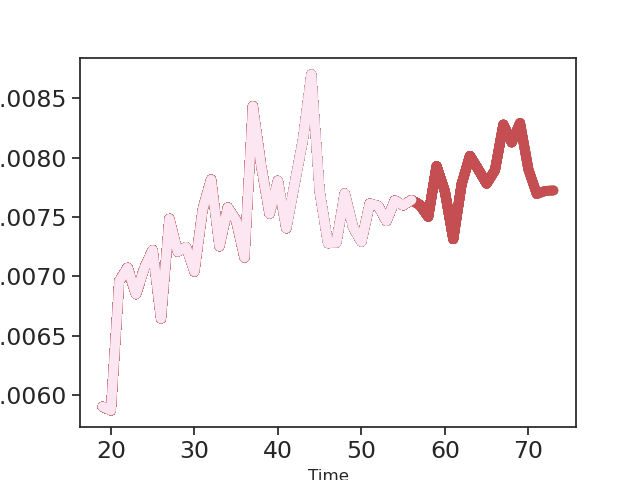

<IPython.core.display.Javascript object>


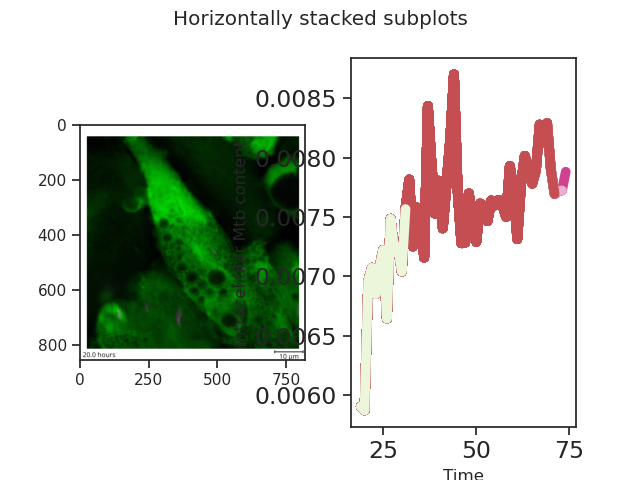

<IPython.core.display.Javascript object>


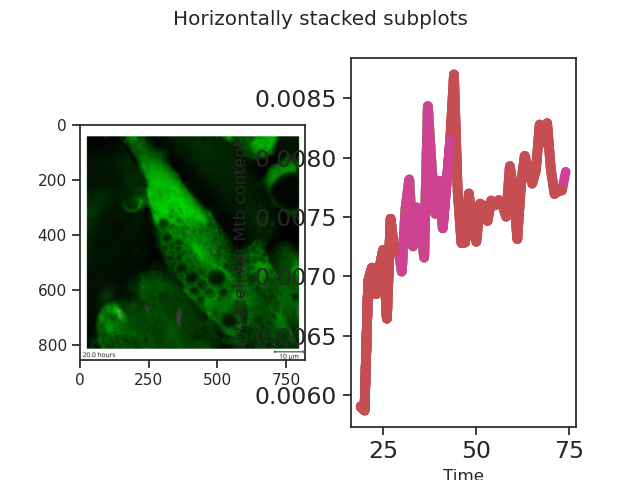

<IPython.core.display.Javascript object>


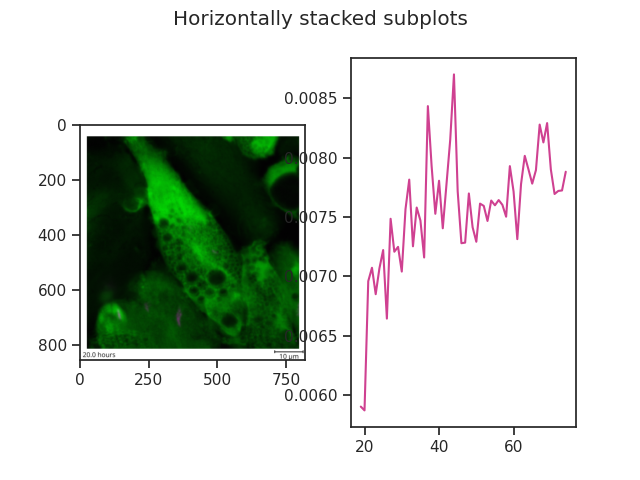

In [981]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(imread('/home/dayn/Videos/tb_mp4s/glimpses/pierre_data/jan_22/glimpse_431_seq/t_20.tiff'))
ax2.plot(x, y)
plt.show()

# Handpicking cells

In [151]:
IDs = [2239, 86, 969, 370, ### high int
      275, 287, 211, 245] ### low int

In [152]:
interest_tracks = [track for track in tracks if track.ID in IDs]

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0, 0.5, 'Intracellular Mtb content \n(Relative fluorescent intensity)')

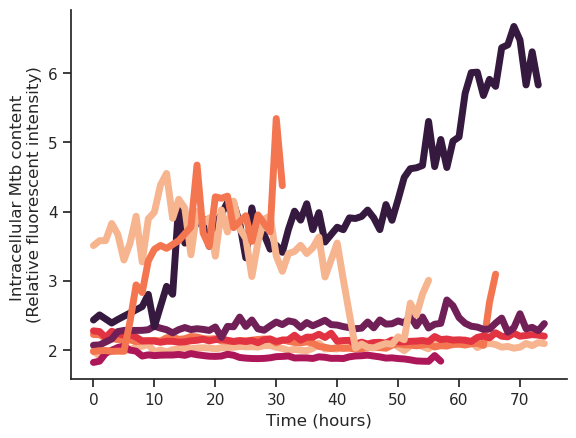

In [197]:
for n, i in tqdm(enumerate(interest_tracks), total = len(interest_tracks)):
    label = f'Cell ID {i.ID}'
    sns.lineplot(data = i.properties['mean_intensity-1']/1E-17, 
#                      label =label, 
                     linewidth = 5
                      )
    sns.despine(offset=0) 
plt.xlabel('Time (hours)')
plt.ylabel('Intracellular Mtb content \n(Relative fluorescent intensity)')

# Smoothing

In [172]:
import pandas as pd

In [175]:
list(pd.Series(y).interpolate())

[1.8238063978338412,
 1.8423547041213306,
 1.9558947199437107,
 1.9979902656557842,
 2.0400858113678577,
 2.059135158518671,
 2.0026590888096947,
 1.9866685577606347,
 1.9162170584960105,
 1.9332179297486083,
 1.9224011062918793,
 1.9286831859956515,
 1.9310088618486023,
 1.9312014530688792,
 1.9391299071725172,
 1.926223490471384,
 1.9521400001465095,
 1.9351059714077221,
 1.9235906701330927,
 1.913669931566415,
 1.9109942066963226,
 1.9162477279734182,
 1.9418001774807818,
 1.9282658015907763,
 1.8955693773972453,
 1.8861938177842865,
 1.8806517845821817,
 1.8793597979245373,
 1.882248709220338,
 1.891039996952278,
 1.907390656404174,
 1.9107558689911304,
 1.9166916117996264,
 1.8881159404562442,
 1.8900657758384352,
 1.889373671892682,
 1.8808417085085438,
 1.9054035575194062,
 1.8981143288228348,
 1.8825927807260852,
 1.8837164873296874,
 1.8801693171757305,
 1.9052384776333728,
 1.9168910754017714,
 1.9207964926917096,
 1.929257111630691,
 1.9162512325407344,
 1.9043637886827662,


  0%|          | 0/8 [00:00<?, ?it/s]

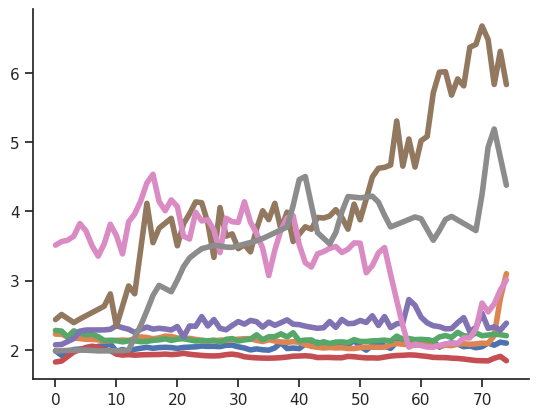

In [185]:
from scipy.interpolate import make_interp_spline, BSpline


for n, i in tqdm(enumerate(interest_tracks), total = len(interest_tracks)):
    x = i.t
    y = i.properties['mean_intensity-1']/1E-17
    y = list(pd.Series(y).interpolate())
    xnew = np.linspace(np.min(x), np.max(x), 75) 
    spl = make_interp_spline(x, y, k=1)
    y_smooth = spl(xnew)
    sns.lineplot(data =y_smooth, 
#                      label =label, 
                     linewidth = 4
                      )
    sns.despine(offset=0) 